# data preparation

In [1]:
import pandas as pd
# from factor_analyzer import FactorAnalyzer
# from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import numpy as np

data_path = "G:\ABCD\script/trail/trail_tsne_RF"
# load data and drop the first column and the subject id
data_raw = pd.read_csv(data_path + "/merged.csv")
label_columns = data_raw.columns[data_raw.columns.str.startswith("cbcl")].tolist()

data_raw = data_raw[["src_subject_id"] + label_columns]

#out put directory
rotation = "NA"
output_dir = "G:/ABCD/script/trail/trail_tsne_RF/factor analysis/output/" + rotation


In [2]:
#drop the subject id for data_raw
data = data_raw.drop("src_subject_id", axis=1)

In [2]:
#read form abcd_y_lt.csv
abcd_y_lt = pd.read_csv("G:\ABCD\\data\\abcd_y_lt.csv")
twins = abcd_y_lt[["src_subject_id", "rel_family_id"]]
twins_unique = twins.drop_duplicates(subset='src_subject_id', keep='first')
# 假设 data 是另一个包含 src_subject_id 和其他列的 DataFrame
merged_data = pd.merge(twins_unique, data_raw, on="src_subject_id", how="inner")
# 假设你的 DataFrame 叫做 df，且 rel_family_id 是你要分析的列
value_counts = merged_data['rel_family_id'].value_counts()

# 找出所有不同的重复次数
unique_counts = value_counts.value_counts().index.sort_values()

# 循环输出每个重复次数的数量
for count in unique_counts:
    count_of_duplicates = (value_counts == count).sum()
    print(f"{count}个相同值的数量: {count_of_duplicates}")

data = merged_data.groupby('rel_family_id').apply(lambda x: x.sample(1)).reset_index(drop=True)

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2816\2767713118.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  abcd_y_lt = pd.read_csv("G:\ABCD\\data\\abcd_y_lt.csv")


1个相同值的数量: 7590
2个相同值的数量: 1701
3个相同值的数量: 54
4个相同值的数量: 2


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2816\2767713118.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = merged_data.groupby('rel_family_id').apply(lambda x: x.sample(1)).reset_index(drop=True)


In [4]:
data = data.drop(columns=["src_subject_id", "rel_family_id"])
# data.to_csv(output_dir + "/data.csv", index=False)

In [5]:
# delete columns with low frequency (more than 99.5% of the values are 0)
low_frequency_columns = data.columns[data.apply(lambda col: (col == 0).mean() > 0.995)]
data_cleaned = data.drop(columns=low_frequency_columns)
print(f"Removed columns with low frequency: {low_frequency_columns.tolist()}")

#load corerlation matrix from polychoric correlation matrix

correlation_matrix = pd.read_csv(data_path + "/factor analysis/output/NA/correlation.csv", index_col=0)

# mark highly correlated pairs (r > 0.75)
high_corr_pairs = (correlation_matrix.abs() > 0.75).where(lambda x: np.triu(x, 1)).stack().index.tolist()
print(f"Highly correlated pairs (r > 0.75): {high_corr_pairs}")
from collections import defaultdict

def find_connected_groups(pairs):
    # 建立图结构
    graph = defaultdict(set)
    for col1, col2 in pairs:
        graph[col1].add(col2)
        graph[col2].add(col1)
    
    # 深度优先搜索（DFS）找到所有连通分量
    visited = set()
    connected_groups = []

    def dfs(node, group):
        visited.add(node)
        group.add(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor, group)

    # 遍历所有节点，找到每个连通分量
    for node in graph:
        if node not in visited:
            group = set()
            dfs(node, group)
            connected_groups.append(tuple(sorted(group)))

    return connected_groups

# 使用函数
result = find_connected_groups(high_corr_pairs)
print("number of connected groups:", len(result))
print("columns for each connected group:", result)
#create dataframe to store the final data
data_final = data_cleaned.copy()
for group in result:
    # calculate the average of the columns in the group
    data_final[f"avg_{'_'.join(group)}"] = data_cleaned[list(group)].mean(axis=1).round().astype(int)
    # delete the original columns
    data_final.drop(columns=list(group), inplace=True)

Removed columns with low frequency: ['cbcl_q02_p', 'cbcl_q73_p', 'cbcl_q99_p', 'cbcl_q101_p', 'cbcl_q105_p']
Highly correlated pairs (r > 0.75): [('cbcl_q08_p', 'cbcl_q10_p'), ('cbcl_q08_p', 'cbcl_q78_p'), ('cbcl_q16_p', 'cbcl_q97_p'), ('cbcl_q20_p', 'cbcl_q21_p'), ('cbcl_q22_p', 'cbcl_q28_p'), ('cbcl_q23_p', 'cbcl_q28_p'), ('cbcl_q25_p', 'cbcl_q48_p'), ('cbcl_q53_p', 'cbcl_q55_p'), ('cbcl_q57_p', 'cbcl_q97_p'), ('cbcl_q81_p', 'cbcl_q82_p')]
number of connected groups: 7
columns for each connected group: [('cbcl_q08_p', 'cbcl_q10_p', 'cbcl_q78_p'), ('cbcl_q16_p', 'cbcl_q57_p', 'cbcl_q97_p'), ('cbcl_q20_p', 'cbcl_q21_p'), ('cbcl_q22_p', 'cbcl_q23_p', 'cbcl_q28_p'), ('cbcl_q25_p', 'cbcl_q48_p'), ('cbcl_q53_p', 'cbcl_q55_p'), ('cbcl_q81_p', 'cbcl_q82_p')]


# autoencoder

In [6]:
data = data_final

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Data Normalization
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 2. Define a Simplified Autoencoder Structure
input_dim = data.shape[1]
encoding_dim = 5  # Capturing five main features

# Input Layer
input_layer = Input(shape=(input_dim,))

# Encoding Layer
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoding Layer
decoded = Dense(input_dim, activation='linear')(encoded)

# Construct Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder Model (to extract features)
encoder = Model(inputs=input_layer, outputs=encoded)

# 3. Compile and Train the Model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
autoencoder.fit(data_scaled, data_scaled, epochs=100, batch_size=32, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

# 4. Extract Main Components
encoded_data = encoder.predict(data_scaled)

# Convert the extracted components to a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=[f'PC{i+1}' for i in range(encoding_dim)])

# View the extracted components
print(encoded_df.head())


Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0574 - mae: 0.1356 - val_loss: 0.0377 - val_mae: 0.1302
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0413 - mae: 0.1361 - val_loss: 0.0352 - val_mae: 0.1208
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0381 - mae: 0.1266 - val_loss: 0.0336 - val_mae: 0.1161
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0370 - mae: 0.1241 - val_loss: 0.0327 - val_mae: 0.1144
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0353 - mae: 0.1205 - val_loss: 0.0321 - val_mae: 0.1131
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0351 - mae: 0.1197 - val_loss: 0.0317 - val_mae: 0.1124
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.0357 - mae: 0.1215 - val_loss: 0.0315 - val_mae: 0.1116
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0346 - mae: 0.1192 - val_loss: 0.0313 - val_mae: 0.1111
Epoch 9/100
168/168 ━━━━━━━━━━━━━━

In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 用训练好的Autoencoder对原始数据进行重构
reconstructed_data = autoencoder.predict(data_scaled)

# 计算每个特征的总方差
total_variance = np.var(data_scaled, axis=0)

# 计算重构误差 (MSE)
reconstruction_error = mean_squared_error(data_scaled, reconstructed_data)

# 计算解释的方差比例
variance_explained_total = 1 - (reconstruction_error / np.mean(total_variance))

print(f'Variance Explained: {variance_explained_total:.4f}')


210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
Variance Explained: 0.3031


In [27]:
import numpy as np

# 假设你的负荷矩阵是 loading_matrix，形状为 (n_features, n_factors)
loading_matrix = np.array(encoded_df)  # 替换为你的实际负荷矩阵

# 计算每个因子的解释方差
variance_explained = np.sum(loading_matrix ** 2, axis=0)

# 将解释方差转换为百分比
total_variance = np.sum(variance_explained)
variance_explained_ratio = (variance_explained / total_variance) * 100

# 输出每个因子的解释方差百分比
for i, ratio in enumerate(variance_explained_ratio):
    # print(f'Factor {i+1} Variance Explained: {ratio:.2f}%')
    variance_explained_each = ratio*variance_explained_total
    print(f'Factor {i+1} Variance Explained: {variance_explained_each:.2f}%')


Factor 1 Variance Explained: 4.46%
Factor 2 Variance Explained: 5.89%
Factor 3 Variance Explained: 5.91%
Factor 4 Variance Explained: 7.37%
Factor 5 Variance Explained: 6.69%


In [23]:
import numpy as np

# 假设 data_scaled 是标准化或者缩放后的矩阵
# 识别大部分元素为 0 的行（大于 95% 的元素为 0）
threshold = 0.95  # 定义阈值
zero_fraction = np.mean(data_scaled == 0, axis=1)  # 计算每一行中 0 的比例
rows_to_keep = zero_fraction <= threshold  # 选择那些 0 的比例小于等于 95% 的行

# 只保留非大部分为 0 的行
data_scaled = data_scaled[rows_to_keep, :]

# # 打印处理后的数据
# print("处理后的数据：")
# print(data_scaled)

In [34]:
correlation_matrix = pd.read_csv(data_path + "/factor analysis/output/NA/nmf_loadings.csv", index_col=0)

In [37]:
correlation_matrix

,V1,V2,V3,V4,V5
cbcl_q01_p,3.989038e-02,2.444018e-02,2.220446e-16,2.220446e-16,1.808884e-01
cbcl_q03_p,9.319816e-11,3.094057e-01,4.204389e-02,1.394705e-01,4.359725e-02
cbcl_q04_p,1.392938e-02,5.225275e-02,3.524376e-02,5.949454e-02,3.363701e-01
cbcl_q05_p,7.334232e-02,1.433246e-02,2.220446e-16,2.220446e-16,2.220446e-16
cbcl_q06_p,2.220446e-16,2.220446e-16,2.773437e-02,2.220446e-16,2.220446e-16
...,...,...,...,...,...
cbcl_q108_p,2.220446e-16,2.220446e-16,1.627950e-01,2.220446e-16,2.220446e-16
cbcl_q109_p,5.009898e-02,1.153337e-01,5.627567e-02,7.371634e-02,2.369333e-02
cbcl_q110_p,4.994746e-03,1.533680e-03,7.240329e-04,2.220446e-16,2.220446e-16
cbcl_q111_p,6.195912e-02,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16


In [154]:
#按照因子的V1的大小排序
correlation_matrix.reindex(correlation_matrix['V5'].abs().sort_values(ascending=False).index)

,V1,V2,V3,V4,V5
cbcl_q78_p,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,5.604418e-01
cbcl_q08_p,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,5.040500e-01
cbcl_q10_p,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,4.114465e-01
cbcl_q04_p,1.392938e-02,5.225275e-02,3.524376e-02,5.949454e-02,3.363701e-01
cbcl_q17_p,5.066473e-02,2.220446e-16,2.220446e-16,2.220446e-16,2.520370e-01
...,...,...,...,...,...
cbcl_q34_p,3.319961e-02,2.184172e-02,2.220446e-16,2.220446e-16,2.220446e-16
cbcl_q77_p,3.474557e-02,3.704395e-03,1.746362e-02,2.220446e-16,2.220446e-16
cbcl_q54_p,4.278502e-02,7.263356e-10,1.766913e-02,2.220446e-16,2.220446e-16
cbcl_q30_p,4.513445e-02,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16


In [179]:
df = pd.DataFrame()
for i in range(5):
    df0 = correlation_matrix['V{0}'.format(i+1)].reindex(
        correlation_matrix['V{0}'.format(i+1)].abs().sort_values(ascending=False).index
    ).to_frame(name='V{0}'.format(i+1))
    df0 = df0.reset_index().rename(columns={'index': 'Row_Name'})
    df = pd.concat([df, df0], axis=1)


In [209]:
from utils import translate_text
# G:\ABCD\script\trail\trail_tsne_RF\factor analysis\utils.py

In [205]:
df.index

RangeIndex(start=0, stop=114, step=1)

In [311]:
for i in range(0, number_of_factors):
    print(i)

0


In [313]:
def translate_text(df, number_of_factors):

    # 解析 element.html 文件以获取列名和详细信息
    with open("data/element.html", "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")

    # 创建一个字典来存储列名和对应的详细信息
    column_details = {}
    result_df = pd.DataFrame()

    # 提取 cbcl_q 列名的正则表达式
    cbcl_pattern = re.compile(r"(cbcl_q\d+[a-z]*_p)")

    for i in range(0, number_of_factors):
        # 筛选出符合条件的加载值
        # factor_values = df[f"Factor {i}"][df[f"Factor {i}"] > 0.1]
        
        original_text = []
        translated_text = []
        for column_name in df.iloc[:,i]:
            # 查找 column_name 中的所有 cbcl_q 字段
            cbcl_items = cbcl_pattern.findall(column_name)  # 提取所有符合 cbcl_qXX_p 或 cbcl_qXXh_p 格式的子串

            # 初始化存储每个 cbcl 字段详细信息的列表
            original = []
            details = []
            for cbcl_item in cbcl_items:
                # 获取每个 cbcl 字段的详细信息
                target = soup.find(lambda tag: tag.name == "td" and cbcl_item in tag.get_text(strip=True))
                if target:
                    detail_info = target.find_next("td").get_text(strip=True)
                    # 保存原始详细信息
                    original.append(detail_info)
                    
                    # 翻译详细信息并添加到结果
                    try:
                        translated_detail = GoogleTranslator(source='es', target='zh-CN').translate(detail_info)
                    except AttributeError as e:
                        print(f"An error occurred: {e}")
                        translated_detail = detail_info
                    details.append(translated_detail)
                    time.sleep(0.25)

            # 将所有细节合并为单个字符串，并添加到列表中
            original_text.append("; ".join(original) if original else "N/A")
            translated_text.append("; ".join(details) if details else "N/A")
        # 创建一个临时数据框保存因子名、列名、加载值和详细信息
        temp_df = pd.DataFrame({
            # f"Factor {i} Variable": factor_values.index,  # 存储列名
            # f"Factor {i} Loading": factor_values.values,  # 存储加载值
            f"Factor {i} Detail": original_text,  # 映射详细信息
            f"Factor {i} Translated_Detail": translated_text  # 映射翻译后详细信息
        })

        # 按加载值降序排序
        # sorted_df = temp_df.sort_values(by=f"Factor {i} Loading", ascending=False).reset_index(drop=True)
        # 将临时数据框合并到结果数据框
        result_df = pd.concat([result_df.reset_index(drop=True), temp_df.reset_index(drop=True)], axis=1)
    return result_df


In [307]:
df = df.iloc[:, [0]]
number_of_factors =1 
# 解析 element.html 文件以获取列名和详细信息
with open("data/element.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# 创建一个字典来存储列名和对应的详细信息
column_details = {}
result_df = pd.DataFrame()

# 提取 cbcl_q 列名的正则表达式
cbcl_pattern = re.compile(r"(cbcl_q\d+[a-z]*_p)")

for i in range(0, number_of_factors + 1):
    # 筛选出符合条件的加载值
    # factor_values = df[f"Factor {i}"][df[f"Factor {i}"] > 0.1]
    
    original_text = []
    translated_text = []
    for column_name in df.iloc[:,i]:
        # 查找 column_name 中的所有 cbcl_q 字段
        cbcl_items = cbcl_pattern.findall(column_name)  # 提取所有符合 cbcl_qXX_p 或 cbcl_qXXh_p 格式的子串

        # 初始化存储每个 cbcl 字段详细信息的列表
        original = []
        details = []
        for cbcl_item in cbcl_items:
            # 获取每个 cbcl 字段的详细信息
            target = soup.find(lambda tag: tag.name == "td" and cbcl_item in tag.get_text(strip=True))
            if target:
                detail_info = target.find_next("td").get_text(strip=True)
                # 保存原始详细信息
                original.append(detail_info)
                
                # 翻译详细信息并添加到结果
                try:
                    translated_detail = GoogleTranslator(source='es', target='zh-CN').translate(detail_info)
                except AttributeError as e:
                    print(f"An error occurred: {e}")
                    translated_detail = detail_info
                details.append(translated_detail)
                time.sleep(0.25)

        # 将所有细节合并为单个字符串，并添加到列表中
        original_text.append("; ".join(original) if original else "N/A")
        translated_text.append("; ".join(details) if details else "N/A")
    # 创建一个临时数据框保存因子名、列名、加载值和详细信息
    temp_df = pd.DataFrame({
        # f"Factor {i} Variable": factor_values.index,  # 存储列名
        # f"Factor {i} Loading": factor_values.values,  # 存储加载值
        f"Factor {i} Detail": original_text,  # 映射详细信息
        f"Factor {i} Translated_Detail": translated_text  # 映射翻译后详细信息
    })

    # 按加载值降序排序
    # sorted_df = temp_df.sort_values(by=f"Factor {i} Loading", ascending=False).reset_index(drop=True)
    # 将临时数据框合并到结果数据框
    result_df = pd.concat([result_df.reset_index(drop=True), temp_df.reset_index(drop=True)], axis=1)



KeyboardInterrupt: 

In [290]:
df['Row_Name']

,Row_Name,Row_Name,Row_Name,Row_Name,Row_Name
0,cbcl_q71_p,cbcl_q22_p,cbcl_q56f_p,cbcl_q44_p,cbcl_q78_p
1,cbcl_q112_p,cbcl_q03_p,cbcl_q56b_p,cbcl_q71_p,cbcl_q08_p
2,cbcl_q50_p,cbcl_q95_p,cbcl_q56e_p,cbcl_q58_p,cbcl_q10_p
3,cbcl_q45_p,cbcl_q28_p,cbcl_q56a_p,cbcl_q55_p,cbcl_q04_p
4,cbcl_q42_p,cbcl_q86_p,cbcl_q49_p,cbcl_q32_p,cbcl_q17_p
...,...,...,...,...,...
109,cbcl_q06_p,cbcl_q92_p,cbcl_q38_p,cbcl_q77_p,cbcl_q34_p
110,cbcl_q81_p,cbcl_q98_p,cbcl_q59_p,cbcl_q01_p,cbcl_q77_p
111,cbcl_q72_p,cbcl_q10_p,cbcl_q63_p,cbcl_q54_p,cbcl_q54_p
112,cbcl_q79_p,cbcl_q08_p,cbcl_q18_p,cbcl_q30_p,cbcl_q30_p


In [305]:
data = df.copy()

In [299]:
df

,Row_Name,V1,Row_Name,V2,Row_Name,V3,Row_Name,V4,Row_Name,V5,CBCL_Details
0,cbcl_q71_p,2.520958e-01,cbcl_q22_p,3.304722e-01,cbcl_q56f_p,3.309346e-01,cbcl_q44_p,5.121333e-01,cbcl_q78_p,5.604418e-01,Self-conscious or easily embarrassed Se cohíbe...
1,cbcl_q112_p,2.348582e-01,cbcl_q03_p,3.094057e-01,cbcl_q56b_p,3.289139e-01,cbcl_q71_p,2.670481e-01,cbcl_q08_p,5.040500e-01,Worries Se preocupa mucho
2,cbcl_q50_p,2.283924e-01,cbcl_q95_p,2.751811e-01,cbcl_q56e_p,2.386312e-01,cbcl_q58_p,1.927971e-01,cbcl_q10_p,4.114465e-01,Too fearful or anxious Demasiado ansioso(a) o ...
3,cbcl_q45_p,1.692854e-01,cbcl_q28_p,2.482104e-01,cbcl_q56a_p,2.303975e-01,cbcl_q55_p,1.913884e-01,cbcl_q04_p,3.363701e-01,"Nervous, highstrung, or tense Nervioso(a), ten..."
4,cbcl_q42_p,1.686497e-01,cbcl_q86_p,2.086195e-01,cbcl_q49_p,1.911072e-01,cbcl_q32_p,1.698548e-01,cbcl_q17_p,2.520370e-01,Would rather be alone than with others Prefier...
...,...,...,...,...,...,...,...,...,...,...,...
109,cbcl_q06_p,2.220446e-16,cbcl_q92_p,2.220446e-16,cbcl_q38_p,2.220446e-16,cbcl_q77_p,2.220446e-16,cbcl_q34_p,2.220446e-16,Bowel movements outside toilet Hace sus necesi...
110,cbcl_q81_p,2.220446e-16,cbcl_q98_p,2.220446e-16,cbcl_q59_p,2.220446e-16,cbcl_q01_p,2.220446e-16,cbcl_q77_p,2.220446e-16,Steals at home Roba en casa
111,cbcl_q72_p,2.220446e-16,cbcl_q10_p,2.220446e-16,cbcl_q63_p,2.220446e-16,cbcl_q54_p,2.220446e-16,cbcl_q54_p,2.220446e-16,Sets fires Prende fuegos/inicia incendios
112,cbcl_q79_p,2.220446e-16,cbcl_q08_p,2.220446e-16,cbcl_q18_p,2.220446e-16,cbcl_q30_p,2.220446e-16,cbcl_q30_p,2.220446e-16,Speech problem Problemas con el habla (describa)


In [302]:
df.iloc[:, [0]]

,Row_Name
0,cbcl_q71_p
1,cbcl_q112_p
2,cbcl_q50_p
3,cbcl_q45_p
4,cbcl_q42_p
...,...
109,cbcl_q06_p
110,cbcl_q81_p
111,cbcl_q72_p
112,cbcl_q79_p


In [317]:
test

,Factor 0 Detail,Factor 0 Translated_Detail
0,Self-conscious or easily embarrassed Se cohíbe...,自我意识或容易感到尴尬
1,Worries Se preocupa mucho,担心 他非常担心
2,Too fearful or anxious Demasiado ansioso(a) o ...,过于恐惧或焦虑
3,"Nervous, highstrung, or tense Nervioso(a), ten...",紧张、高度紧张或紧张
4,Would rather be alone than with others Prefier...,宁愿独自一人也不愿与他人在一起
...,...,...
109,Bowel movements outside toilet Hace sus necesi...,在厕所外排便 他在衣服上或在不适当的地方大小便
110,Steals at home Roba en casa,在家偷窃
111,Sets fires Prende fuegos/inicia incendios,放火 点火/点火
112,Speech problem Problemas con el habla (describa),言语问题 言语问题（描述）


In [316]:
test = translate_text(data.iloc[:, [0]] , 1)

In [ ]:

number_of_factors = 5
# 解析 element.html 文件以获取列名和详细信息
with open("data/element.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# 创建一个字典来存储列名和对应的详细信息
column_details = {}
result_df = pd.DataFrame()

# 提取 cbcl_q 列名的正则表达式
cbcl_pattern = re.compile(r"(cbcl_q\d+[a-z]*_p)")

for i in range(1, number_of_factors + 1):
    # 筛选出符合条件的加载值
    # factor_values = df[f"Factor {i}"][df[f"Factor {i}"] > 0.1]
    
    original_text = []
    translated_text = []
    for column_name in df.iloc[:,i]:
        # 查找 column_name 中的所有 cbcl_q 字段
        cbcl_items = cbcl_pattern.findall(column_name)  # 提取所有符合 cbcl_qXX_p 或 cbcl_qXXh_p 格式的子串

        # 初始化存储每个 cbcl 字段详细信息的列表
        original = []
        details = []
        for cbcl_item in cbcl_items:
            # 获取每个 cbcl 字段的详细信息
            target = soup.find(lambda tag: tag.name == "td" and cbcl_item in tag.get_text(strip=True))
            if target:
                detail_info = target.find_next("td").get_text(strip=True)
                # 保存原始详细信息
                original.append(detail_info)
                
                # 翻译详细信息并添加到结果
                try:
                    translated_detail = GoogleTranslator(source='es', target='zh-CN').translate(detail_info)
                except AttributeError as e:
                    print(f"An error occurred: {e}")
                    translated_detail = detail_info
                details.append(translated_detail)
                time.sleep(0.25)

        # 将所有细节合并为单个字符串，并添加到列表中
        original_text.append("; ".join(original) if original else "N/A")
        translated_text.append("; ".join(details) if details else "N/A")

    temp_df = pd.DataFrame({
        # f"Factor {i} Variable": factor_values.index,  # 存储列名
        # f"Factor {i} Loading": factor_values.values,  # 存储加载值
        f"Factor {i} Detail": original_text,  # 映射详细信息
        f"Factor {i} Translated_Detail": translated_text  # 映射翻译后详细信息
    })

    # 按加载值降序排序
    # sorted_df = temp_df.sort_values(by=f"Factor {i} Loading", ascending=False).reset_index(drop=True)
    # 将临时数据框合并到结果数据框
    result_df = pd.concat([result_df.reset_index(drop=True), temp_df.reset_index(drop=True)], axis=1)

KeyboardInterrupt: 

In [280]:
result_df

,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail
0,Disobedient at home Desobedece en casa,在家不听话,Stomachaches Dolores de estómago,胃痛 胃痛
1,Argues a lot Discute mucho,争论很多 争论很多,Headaches Dolores de cabeza,头痛 头痛
2,Temper tantrums or hot temper Le dan rabietas ...,发脾气或脾气暴躁 他发脾气或脾气不好,Rashes or other skin problems Salpullido o irr...,皮疹或其他皮肤问题
3,"Breaks rules at home, school or elsewhere No r...",违反家庭、学校或其他地方的规则 不尊重/违反家庭、学校或其他地方的规则\n ...,Aches or pains (not stomach or headaches) Dolo...,疼痛（不是胃痛或头痛）\n 头）
4,"Stubborn, sullen, or irritable Obstinado(a), m...",固执、闷闷不乐或易怒,"Constipated, doesn't move bowels Padece de est...",便秘，拉不动大便
...,...,...,...,...
109,Talks or walks in sleep Habla o camina cuando ...,睡觉时说话或走路 睡觉时说话或走路,Gets teased a lot Los demás se burlan de él/el...,经常被取笑其他人经常取笑他/她
110,Thumb-sucking Se chupa el dedo,吮吸拇指,Plays with own sex parts in public Se toca/jue...,在公共场合玩弄自己的性器官
111,"Can't sit still, restless, or hyperactive No p...",无法静坐、焦躁不安或过度活跃焦躁不安或过度活跃,Prefers being with older kids Prefiere estar c...,喜欢和年龄较大的孩子在一起 喜欢和比他/她大的孩子在一起
112,"Can't concentrate, can't pay attention for lon...",无法集中注意力，无法长时间集中注意力,Deliberately harms self or attempts suicide Se...,故意伤害自己或企图自杀\n 自杀


In [262]:
original = []
details = []
for items in  df.iloc[:,i]:
    target = soup.find(lambda tag: tag.name == "td" and items in tag.get_text(strip=True))
    if target:
        detail_info = target.find_next("td").get_text(strip=True)
        original.append(detail_info)
        translated_detail = GoogleTranslator(source='es', target='zh-CN').translate(detail_info)
        translated_text.append(translated_detail)
        time.sleep(0.25)
original_text.append("; ".join(original) if original else "N/A")
translated_text.append("; ".join(details) if details else "N/A")

In [266]:
details

[]

In [218]:
df.iloc[:,i]

0      cbcl_q56f_p
1      cbcl_q56b_p
2      cbcl_q56e_p
3      cbcl_q56a_p
4       cbcl_q49_p
          ...     
109     cbcl_q38_p
110     cbcl_q59_p
111     cbcl_q63_p
112     cbcl_q18_p
113     cbcl_q71_p
Name: Row_Name, Length: 114, dtype: object

In [203]:
df

,Row_Name,V1,Row_Name,V2,Row_Name,V3,Row_Name,V4,Row_Name,V5,CBCL_Details
0,cbcl_q71_p,2.520958e-01,cbcl_q22_p,3.304722e-01,cbcl_q56f_p,3.309346e-01,cbcl_q44_p,5.121333e-01,cbcl_q78_p,5.604418e-01,Self-conscious or easily embarrassed Se cohíbe...
1,cbcl_q112_p,2.348582e-01,cbcl_q03_p,3.094057e-01,cbcl_q56b_p,3.289139e-01,cbcl_q71_p,2.670481e-01,cbcl_q08_p,5.040500e-01,Worries Se preocupa mucho
2,cbcl_q50_p,2.283924e-01,cbcl_q95_p,2.751811e-01,cbcl_q56e_p,2.386312e-01,cbcl_q58_p,1.927971e-01,cbcl_q10_p,4.114465e-01,Too fearful or anxious Demasiado ansioso(a) o ...
3,cbcl_q45_p,1.692854e-01,cbcl_q28_p,2.482104e-01,cbcl_q56a_p,2.303975e-01,cbcl_q55_p,1.913884e-01,cbcl_q04_p,3.363701e-01,"Nervous, highstrung, or tense Nervioso(a), ten..."
4,cbcl_q42_p,1.686497e-01,cbcl_q86_p,2.086195e-01,cbcl_q49_p,1.911072e-01,cbcl_q32_p,1.698548e-01,cbcl_q17_p,2.520370e-01,Would rather be alone than with others Prefier...
...,...,...,...,...,...,...,...,...,...,...,...
109,cbcl_q06_p,2.220446e-16,cbcl_q92_p,2.220446e-16,cbcl_q38_p,2.220446e-16,cbcl_q77_p,2.220446e-16,cbcl_q34_p,2.220446e-16,Bowel movements outside toilet Hace sus necesi...
110,cbcl_q81_p,2.220446e-16,cbcl_q98_p,2.220446e-16,cbcl_q59_p,2.220446e-16,cbcl_q01_p,2.220446e-16,cbcl_q77_p,2.220446e-16,Steals at home Roba en casa
111,cbcl_q72_p,2.220446e-16,cbcl_q10_p,2.220446e-16,cbcl_q63_p,2.220446e-16,cbcl_q54_p,2.220446e-16,cbcl_q54_p,2.220446e-16,Sets fires Prende fuegos/inicia incendios
112,cbcl_q79_p,2.220446e-16,cbcl_q08_p,2.220446e-16,cbcl_q18_p,2.220446e-16,cbcl_q30_p,2.220446e-16,cbcl_q30_p,2.220446e-16,Speech problem Problemas con el habla (describa)


In [180]:
df

,Row_Name,V1,Row_Name,V2,Row_Name,V3,Row_Name,V4,Row_Name,V5
0,cbcl_q71_p,2.520958e-01,cbcl_q22_p,3.304722e-01,cbcl_q56f_p,3.309346e-01,cbcl_q44_p,5.121333e-01,cbcl_q78_p,5.604418e-01
1,cbcl_q112_p,2.348582e-01,cbcl_q03_p,3.094057e-01,cbcl_q56b_p,3.289139e-01,cbcl_q71_p,2.670481e-01,cbcl_q08_p,5.040500e-01
2,cbcl_q50_p,2.283924e-01,cbcl_q95_p,2.751811e-01,cbcl_q56e_p,2.386312e-01,cbcl_q58_p,1.927971e-01,cbcl_q10_p,4.114465e-01
3,cbcl_q45_p,1.692854e-01,cbcl_q28_p,2.482104e-01,cbcl_q56a_p,2.303975e-01,cbcl_q55_p,1.913884e-01,cbcl_q04_p,3.363701e-01
4,cbcl_q42_p,1.686497e-01,cbcl_q86_p,2.086195e-01,cbcl_q49_p,1.911072e-01,cbcl_q32_p,1.698548e-01,cbcl_q17_p,2.520370e-01
...,...,...,...,...,...,...,...,...,...,...
109,cbcl_q06_p,2.220446e-16,cbcl_q92_p,2.220446e-16,cbcl_q38_p,2.220446e-16,cbcl_q77_p,2.220446e-16,cbcl_q34_p,2.220446e-16
110,cbcl_q81_p,2.220446e-16,cbcl_q98_p,2.220446e-16,cbcl_q59_p,2.220446e-16,cbcl_q01_p,2.220446e-16,cbcl_q77_p,2.220446e-16
111,cbcl_q72_p,2.220446e-16,cbcl_q10_p,2.220446e-16,cbcl_q63_p,2.220446e-16,cbcl_q54_p,2.220446e-16,cbcl_q54_p,2.220446e-16
112,cbcl_q79_p,2.220446e-16,cbcl_q08_p,2.220446e-16,cbcl_q18_p,2.220446e-16,cbcl_q30_p,2.220446e-16,cbcl_q30_p,2.220446e-16


In [200]:
# 使用 iloc 获取第一列并转换为 Series，然后调用 apply()
details = []
for i in range(5):
    detail = df.iloc[:, i*2].apply(get_cbcl_details)
    details.append(detail)
details = pd.concat(details, axis=1)

In [268]:
test = df['Row_Name'].iloc[:,:1].apply(get_cbcl_details)


TypeError: expected string or bytes-like object

In [ ]:
import pandas as pd


correlation_matrix = encoded_df.join(data).corr()
#load csv

correlation_matrix_filtered = correlation_matrix.drop(["PC1", "PC2", "PC3", "PC4", "PC5"]).loc[:, "PC1":"PC5"]
correlation_matrix_filtered

NameError: name 'correlation_matrix_filtered' is not defined

In [148]:
# 获取索引和指定的列
index_list = correlation_matrix.index
# columns = ["PC1", "PC2", "PC3", "PC4", "PC5"]
columns = ["V1", "V2", "V3", "V4", "V5"]

# 初始化空的列表用于存储新数据
new_data = []

# 交替排列 index 和每个 PC 列
for col in columns:
    new_data.append(index_list)
    new_data.append(correlation_matrix[col].values)

# 转置数据并创建 DataFrame
new_df = pd.DataFrame(list(zip(*new_data)), columns=["Index1", "PC1", "Index2", "PC2", "Index3", "PC3", "Index4", "PC4", "Index5", "PC5"])

new_df = new_df.drop(index=[0, 1, 2, 3, 4])
new_df

,Index1,PC1,Index2,PC2,Index3,PC3,Index4,PC4,Index5,PC5
5,cbcl_q07_p,2.220446e-16,cbcl_q07_p,1.173915e-01,cbcl_q07_p,2.220446e-16,cbcl_q07_p,1.089160e-01,cbcl_q07_p,5.073395e-02
6,cbcl_q08_p,2.220446e-16,cbcl_q08_p,2.220446e-16,cbcl_q08_p,2.220446e-16,cbcl_q08_p,2.220446e-16,cbcl_q08_p,5.040500e-01
7,cbcl_q09_p,1.195485e-01,cbcl_q09_p,2.220446e-16,cbcl_q09_p,2.220446e-16,cbcl_q09_p,2.220446e-16,cbcl_q09_p,1.861457e-01
8,cbcl_q10_p,2.220446e-16,cbcl_q10_p,2.220446e-16,cbcl_q10_p,2.220446e-16,cbcl_q10_p,2.220446e-16,cbcl_q10_p,4.114465e-01
9,cbcl_q11_p,1.398559e-01,cbcl_q11_p,5.412335e-12,cbcl_q11_p,2.220446e-16,cbcl_q11_p,2.220446e-16,cbcl_q11_p,4.863420e-02
...,...,...,...,...,...,...,...,...,...,...
109,cbcl_q108_p,2.220446e-16,cbcl_q108_p,2.220446e-16,cbcl_q108_p,1.627950e-01,cbcl_q108_p,2.220446e-16,cbcl_q108_p,2.220446e-16
110,cbcl_q109_p,5.009898e-02,cbcl_q109_p,1.153337e-01,cbcl_q109_p,5.627567e-02,cbcl_q109_p,7.371634e-02,cbcl_q109_p,2.369333e-02
111,cbcl_q110_p,4.994746e-03,cbcl_q110_p,1.533680e-03,cbcl_q110_p,7.240329e-04,cbcl_q110_p,2.220446e-16,cbcl_q110_p,2.220446e-16
112,cbcl_q111_p,6.195912e-02,cbcl_q111_p,2.220446e-16,cbcl_q111_p,2.220446e-16,cbcl_q111_p,2.220446e-16,cbcl_q111_p,2.220446e-16


In [ ]:
# 定义列对的索引
column_pairs = [("Index1", "PC1"), ("Index2", "PC2"), ("Index3", "PC3"), ("Index4", "PC4"), ("Index5", "PC5")]

# 对每对列进行单独排序
for index_col, pc_col in column_pairs:
    # 只对当前的列对进行排序，不影响其他列
    new_df[[index_col, pc_col]] = new_df[[index_col, pc_col]].sort_values(by=pc_col, ascending=False).values

# new_df.to_csv("correlation_matrix.csv",index=False)

In [44]:
new_df

,Index1,PC1,Index2,PC2,Index3,PC3,Index4,PC4,Index5,PC5
5,cbcl_q71_p,0.252096,cbcl_q22_p,0.330472,cbcl_q56f_p,0.330935,cbcl_q44_p,0.512133,cbcl_q78_p,0.560442
6,cbcl_q112_p,0.234858,cbcl_q95_p,0.275181,cbcl_q56b_p,0.328914,cbcl_q71_p,0.267048,cbcl_q08_p,0.50405
7,cbcl_q50_p,0.228392,cbcl_q28_p,0.24821,cbcl_q56e_p,0.238631,cbcl_q58_p,0.192797,cbcl_q10_p,0.411447
8,cbcl_q45_p,0.169285,cbcl_q86_p,0.20862,cbcl_q56a_p,0.230398,cbcl_q55_p,0.191388,cbcl_q17_p,0.252037
9,cbcl_q42_p,0.16865,cbcl_q43_p,0.200406,cbcl_q49_p,0.191107,cbcl_q32_p,0.169855,cbcl_q93_p,0.211002
...,...,...,...,...,...,...,...,...,...,...
109,cbcl_q60_p,0.0,cbcl_q56h_p,0.0,cbcl_q23_p,0.0,cbcl_q52_p,0.0,cbcl_q51_p,0.0
110,cbcl_q61_p,0.0,cbcl_q62_p,0.0,cbcl_q25_p,0.0,cbcl_q51_p,0.0,cbcl_q50_p,0.0
111,cbcl_q67_p,0.0,cbcl_q64_p,0.0,cbcl_q08_p,0.0,cbcl_q50_p,0.0,cbcl_q49_p,0.0
112,cbcl_q68_p,0.0,cbcl_q70_p,0.0,cbcl_q26_p,0.0,cbcl_q49_p,0.0,cbcl_q48_p,0.0


In [13]:
new_df

,Index1,PC1,Index2,PC2,Index3,PC3,Index4,PC4,Index5,PC5
5,cbcl_q44_p,0.658562,cbcl_q112_p,0.749548,cbcl_q87_p,0.625685,cbcl_q41_p,0.691131,cbcl_q03_p,0.719998
6,cbcl_q45_p,0.563849,cbcl_q50_p,0.661836,cbcl_q86_p,0.600941,avg_cbcl_q08_p_cbcl_q10_p_cbcl_q78_p,0.668094,cbcl_q95_p,0.706209
7,avg_cbcl_q08_p_cbcl_q10_p_cbcl_q78_p,0.562464,cbcl_q71_p,0.659321,cbcl_q95_p,0.590855,cbcl_q93_p,0.65752,cbcl_q86_p,0.705767
8,cbcl_q86_p,0.560706,cbcl_q32_p,0.618183,avg_cbcl_q08_p_cbcl_q10_p_cbcl_q78_p,0.58445,cbcl_q19_p,0.657316,cbcl_q87_p,0.617334
9,cbcl_q41_p,0.551942,cbcl_q45_p,0.603183,cbcl_q03_p,0.577649,cbcl_q03_p,0.65202,cbcl_q27_p,0.561603
...,...,...,...,...,...,...,...,...,...,...
103,cbcl_q56g_p,0.118983,cbcl_q60_p,0.067201,cbcl_q72_p,0.106907,cbcl_q56d_p,0.095307,cbcl_q107_p,0.071093
104,cbcl_q59_p,0.101791,cbcl_q59_p,0.063268,cbcl_q59_p,0.09496,cbcl_q06_p,0.091715,cbcl_q98_p,0.042366
105,cbcl_q72_p,0.101046,cbcl_q108_p,0.062521,cbcl_q110_p,0.076616,cbcl_q98_p,0.05389,cbcl_q110_p,0.032064
106,cbcl_q110_p,0.074265,cbcl_q98_p,0.041541,cbcl_q98_p,0.053602,cbcl_q110_p,0.052574,cbcl_q79_p,0.016709


In [76]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load data from dataframe
d = data.shape[1]  # Input dimension based on dataframe
X = data.values  # Convert dataframe to numpy array

# Define a function to build a deep autoencoder model
def build_autoencoder(input_dim, J):
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Encoder layers
    encoded = Dense(8 * J, activation='relu')(input_layer)
    bottleneck = Dense(J, activation='relu')(encoded)
    
    # Decoder layers
    decoded = Dense(8 * J, activation='relu')(bottleneck)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    
    # Define the autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

# Grid search for optimal J (1 <= J <= 10)
min_rmse = float('inf')
optimal_J = None
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for J in range(1, 11):
    rmses = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        
        # Build and compile the model
        autoencoder = build_autoencoder(input_dim=d, J=J)
        autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
        
        # Train the model
        autoencoder.fit(X_train, X_train, epochs=100, batch_size=64, verbose=0, validation_data=(X_val, X_val))
        
        # Predict on validation set
        X_val_pred = autoencoder.predict(X_val)
        
        # Calculate RMSE
        rmse = sqrt(mean_squared_error(X_val, X_val_pred))
        rmses.append(rmse)
    
    # Average RMSE for current J
    avg_rmse = np.mean(rmses)
    print(f'J = {J}, Average RMSE: {avg_rmse}')
    
    # Update optimal J
    if avg_rmse < min_rmse:
        min_rmse = avg_rmse
        optimal_J = J

print(f'Optimal J: {optimal_J}, Minimum RMSE: {min_rmse}')

# Build the final model with the optimal J
autoencoder = build_autoencoder(input_dim=d, J=optimal_J)
autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the final model on the entire dataset
autoencoder.fit(X, X, epochs=100, batch_size=64, verbose=1)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
J = 1, Average RMSE: 0.33886045973714163
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
J = 2, Average RMSE: 0.3257940067190376
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━

In [184]:
from bs4 import BeautifulSoup
from googletrans import Translator
import re
import time

# 指定源语言和目标语言
translator = Translator()

def get_cbcl_details(cbcl_item):
    """
    根据提供的 cbcl_q 字段组合（如 "avg_cbcl_q08_p_cbcl_q10_p_cbcl_q78_p"）从 element.html 文件中获取详细信息。
    
    参数:
        cbcl_item (str): 要查找的 cbcl_q 字段组合（如 "avg_cbcl_q08_p_cbcl_q10_p_cbcl_q78_p"）。
    
    返回:
        str: 详细信息的组合，如果找不到则返回 "N/A"。
    """
    # 解析 element.html 文件
    with open("data/element.html", "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")

    # 使用正则表达式提取所有的 cbcl_q 字段
    cbcl_pattern = re.compile(r"(cbcl_q\d+[a-z]*_p)")
    cbcl_items = cbcl_pattern.findall(cbcl_item)
    
    # 存储每个 cbcl 字段的详细信息
    details = []

    for cbcl in cbcl_items:
        # 在 HTML 中查找包含 cbcl 的 <td> 标签
        target = soup.find(lambda tag: tag.name == "td" and cbcl in tag.get_text(strip=True))
        
        # 获取详细信息
        if target:
            detail_info = target.find_next("td").get_text(strip=True)
            details.append(detail_info)
        else:
            details.append("N/A")
    
    # 合并所有详细信息为一个字符串
    combined_details = "; ".join(details) if details else "N/A"

    return combined_details

# 示例调用
detail = get_cbcl_details("avg_cbcl_q08_p_cbcl_q10_p_cbcl_q78_p")
print("详细信息:", detail)


详细信息: Can't concentrate, can't pay attention for long No puede concentrarse o prestar atención por mucho tiempo; Can't sit still, restless, or hyperactive No puede quedarse quieto(a); es inquieto(a) o hiperactivo(a); Inattentive or easily distracted No presta atención o se distrae fácilmente


In [ ]:
# 创建空列表来存储每列的详细信息
for col in ["Index1", "Index2", "Index3", "Index4", "Index5"]:
    details = []  # 存储该列的详细信息

    # 对每一行应用 get_cbcl_details 函数
    for cbcl_item in new_df[col]:
        detail_info = get_cbcl_details(cbcl_item)
        details.append(detail_info)

    # 将结果添加到 DataFrame 中
    new_df[f"{col}_Detail"] = details

# 查看添加了详细信息后的 DataFrame
new_df.to_csv("correlation_matrix_with_details.csv",index=False)
new_df.head()


# RF

In [93]:
data_raw.insert(0, 'src_subject_id', X_baseline.iloc[:, 0])


In [96]:
data_raw

,src_subject_id,New_Column,rsfmri_cor_ngd_au_scs_aalh,rsfmri_cor_ngd_au_scs_aarh,rsfmri_cor_ngd_au_scs_aglh,rsfmri_cor_ngd_au_scs_agrh,rsfmri_cor_ngd_au_scs_bs,rsfmri_cor_ngd_au_scs_cdelh,rsfmri_cor_ngd_au_scs_cderh,rsfmri_cor_ngd_au_scs_crcxlh,...,rsfmri_var_cortgordon_gp91lh,rsfmri_var_cortgordon_gp92lh,rsfmri_var_cortgordon_gp93lh,rsfmri_var_cortgordon_gp94lh,rsfmri_var_cortgordon_gp95lh,rsfmri_var_cortgordon_gp96lh,rsfmri_var_cortgordon_gp97lh,rsfmri_var_cortgordon_gp98lh,rsfmri_var_cortgordon_gp99lh,rsfmri_var_cortgordon_gp9lh
0,NDAR_INV003RTV85,NDAR_INV003RTV85,-0.090258,-0.083909,0.004247,-0.054861,-0.048167,0.036012,0.013843,-0.020096,...,0.070026,0.241027,0.271503,0.141462,0.140140,0.037668,0.294336,0.213838,0.045987,0.094689
1,NDAR_INV005V6D2C,NDAR_INV005V6D2C,-0.098593,0.093085,-0.170801,-0.134319,-0.022124,0.092985,0.061854,0.011913,...,0.072261,0.125446,0.118057,0.177558,0.069124,0.061450,0.101900,0.423981,0.086047,0.103453
2,NDAR_INV007W6H7B,NDAR_INV007W6H7B,-0.065449,0.122893,-0.006246,-0.118878,-0.027118,-0.026523,-0.045971,-0.065351,...,0.022169,0.028780,0.084394,0.024809,0.097594,0.034820,0.034840,0.076949,0.030869,0.236822
3,NDAR_INV00BD7VDC,NDAR_INV00BD7VDC,-0.148170,-0.049085,-0.026814,-0.028232,0.008625,-0.153769,-0.073198,-0.138927,...,0.032624,0.046383,0.059366,0.059687,0.046924,0.041598,0.038637,0.048176,0.017002,0.426372
4,NaN,NaN,-0.148117,0.037320,-0.104190,-0.037308,0.121178,0.034533,-0.183537,-0.258663,...,0.039444,0.101833,0.102724,0.049330,0.080309,0.085158,0.106023,0.117981,0.048400,0.040434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,NaN,NaN,0.030591,0.003116,-0.138875,-0.096117,-0.008607,-0.111538,-0.111535,-0.161508,...,0.068745,0.182518,0.110985,0.041953,0.068067,0.086526,0.072267,0.164568,0.021918,0.070268
11158,NDAR_INVG0F3TJPW,NDAR_INVG0F3TJPW,-0.089590,-0.002218,-0.150480,0.052007,0.119924,-0.258660,-0.164504,-0.068733,...,0.061562,0.083194,0.093745,0.040504,0.053332,0.052622,0.071286,0.128881,0.016509,0.050277
11159,NaN,NaN,-0.112247,-0.010195,0.038551,-0.112359,-0.043313,0.045530,-0.188547,-0.048601,...,0.024539,0.101225,0.131841,0.026207,0.046078,0.036895,0.150434,0.087546,0.037467,0.026891
11160,NDAR_INVG0GY52R2,NDAR_INVG0GY52R2,0.051633,-0.127992,-0.172488,0.013249,-0.014129,-0.236400,-0.056846,0.076282,...,0.051574,0.056057,0.125025,0.052557,0.061239,0.088988,0.085553,0.625010,0.046204,0.032801


In [103]:
data_raw = data_raw.drop(columns = "New_Column")

In [106]:
# feature_raw = pd.read_csv("G:\ABCD\data\mri_y_rsfmr_cor_gp_aseg.csv")
feature_raw = pd.read_csv("G:\ABCD\data\mri_y_rsfmr_cor_gp_aseg.csv")
# merge data and X on src_subject_id

X_baseline = feature_raw[feature_raw["eventname"] == "baseline_year_1_arm_1"]



In [107]:
# 将 data 和 X 按照 "src_subject_id" 列合并
merged_df = pd.merge(data["src_subject_id"], X_baseline, on="src_subject_id", how="inner")
X = merged_df.drop(columns=["src_subject_id","eventname"], axis=1)

In [108]:
X

,rsfmri_cor_ngd_au_scs_aalh,rsfmri_cor_ngd_au_scs_aarh,rsfmri_cor_ngd_au_scs_aglh,rsfmri_cor_ngd_au_scs_agrh,rsfmri_cor_ngd_au_scs_bs,rsfmri_cor_ngd_au_scs_cdelh,rsfmri_cor_ngd_au_scs_cderh,rsfmri_cor_ngd_au_scs_crcxlh,rsfmri_cor_ngd_au_scs_crcxrh,rsfmri_cor_ngd_au_scs_hplh,...,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_pllh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_ptlh,rsfmri_cor_ngd_vs_scs_ptrh,rsfmri_cor_ngd_vs_scs_thplh,rsfmri_cor_ngd_vs_scs_thprh,rsfmri_cor_ngd_vs_scs_vtdclh,rsfmri_cor_ngd_vs_scs_vtdcrh
0,0.055373,0.010663,0.077314,0.134695,0.022511,-0.038182,-0.176619,-0.063200,0.011281,0.104524,...,-0.021614,-0.083068,0.036022,-0.003157,0.193484,0.050168,0.026512,0.016188,0.017193,0.053266
1,-0.012065,-0.058936,-0.138518,0.066717,-0.062600,-0.087190,-0.186163,-0.098255,0.088928,-0.002340,...,0.069426,0.025448,-0.071978,0.046170,0.144247,-0.080032,-0.004278,0.002052,0.006714,-0.072794
2,-0.046328,-0.110550,-0.096390,-0.261646,-0.040385,0.258654,-0.155618,-0.188302,-0.300512,0.029960,...,0.578557,0.530182,0.089146,0.222993,0.122496,-0.499588,0.085961,-0.361897,-0.306012,-0.171299
3,-0.029424,-0.098254,-0.157998,-0.006393,-0.046835,0.001867,-0.160298,-0.051735,0.145002,-0.044259,...,0.079179,0.102173,-0.057520,0.015970,0.100648,-0.045624,0.059917,-0.073928,-0.032104,-0.033315
4,-0.028203,-0.006111,-0.045453,-0.041866,-0.034370,-0.050579,-0.131665,-0.049449,-0.020300,-0.080431,...,0.055287,-0.081229,-0.032886,-0.059226,0.093143,0.053695,-0.011197,-0.026894,0.027513,-0.074254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9342,-0.023167,0.018374,-0.115867,0.027363,-0.020531,-0.208167,-0.202320,0.044998,-0.030610,-0.024677,...,0.161818,0.005746,0.037556,0.074350,-0.011557,0.068328,-0.012995,-0.021544,-0.022381,-0.024477
9343,0.060254,0.040693,0.016569,-0.021491,0.052835,0.015180,-0.234214,0.024804,-0.050119,0.074444,...,0.052088,0.080394,-0.014290,0.026424,0.229135,0.076307,-0.086621,-0.088756,0.044557,-0.096324
9344,0.007412,-0.089075,-0.191196,0.021005,0.022065,-0.032718,0.004512,0.055383,-0.276528,-0.012432,...,0.121496,0.066029,0.048063,-0.017240,0.142219,-0.017623,-0.063445,-0.100549,0.085462,0.079171
9345,-0.159067,-0.052097,-0.320385,-0.004716,0.012645,-0.194241,-0.118141,-0.249773,-0.130421,-0.127866,...,0.074095,0.042162,-0.050792,-0.138313,0.166585,0.135075,-0.042237,-0.056728,0.009536,-0.077982


In [101]:
y =encoded_df["PC1"]

In [109]:
y

0       0.669889
1       0.114958
2       0.034764
3       0.290378
4       0.604888
          ...   
9342    0.928409
9343    0.989277
9344    0.252261
9345    0.333049
9346    0.000000
Name: PC1, Length: 9347, dtype: float32

In [77]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 定义深度学习模型
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # 第一层
    keras.layers.Dense(32, activation='relu'),                                   # 第二层
    keras.layers.Dense(1)                                                        # 输出层
])

# 编译模型
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 定义 EarlyStopping 回调
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # 监控验证损失
    patience=10,            # 在 10 个 epoch 内无改进时停止训练
    restore_best_weights=True  # 恢复最佳权重
)

# 训练模型
model.fit(
    X_train, y_train,
    epochs=100,             # 最大迭代次数
    batch_size=32,
    validation_split=0.2,   # 使用部分训练数据进行验证
    callbacks=[early_stopping],  # 添加 EarlyStopping 回调
    verbose=1
)

# 使用模型进行预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算训练集和测试集的 R²（决定系数）
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R² Score on Training Set: {r2_train}")
print(f"R² Score on Test Set: {r2_test}")


Epoch 1/100


c:\Anaconda\envs\Tensorflow\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4173 - mae: 0.4777 - val_loss: 0.2631 - val_mae: 0.3814
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2171 - mae: 0.3537 - val_loss: 0.2574 - val_mae: 0.3864
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2059 - mae: 0.3396 - val_loss: 0.2607 - val_mae: 0.3934
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.1708 - mae: 0.3207 - val_loss: 0.2588 - val_mae: 0.3827
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.1645 - mae: 0.3092 - val_loss: 0.2699 - val_mae: 0.4008
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.1433 - mae: 0.2900 - val_loss: 0.2749 - val_mae: 0.3940
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.1148 - mae: 0.2611 - val_loss: 0.2936 - val_mae: 0.4110
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1089 - mae: 0.2530 - val_loss: 0.2952 - val_mae: 0.4126
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/st

# EFA from previous research

In [ ]:
import pandas as pd
import re

# 原始数据，使用多行字符串（可以替换为您自己的数据）
raw_data = """
| Composite (Attacks/threatens)                                | **0.90** | 0.03     | −0.14    | −0.03    | 0.02     |
| Cruelty, bullying, or meanness to others                     | **0.88** | −0.05    | −0.10    | −0.01    | −0.03    |
| Composite (Disobeys rules)                                   | **0.81** | −0.11    | 0.16     | −0.01    | −0.07    |
| Gets in many fights                                          | **0.78** | −0.13    | 0.02     | 0.01     | 0.05     |
| Temper tantrums or hot temper                                | **0.77** | 0.25     | −0.08    | 0.01     | −0.11    |
| Argues a lot                                                 | **0.76** | 0.18     | 0.02     | 0.01     | −0.19    |
| Composite (Destroys)                                         | **0.72** | −0.06    | 0.15     | −0.01    | 0.06     |
| Screams a lot                                                | **0.72** | 0.17     | −0.03    | 0.01     | −0.04    |
| Doesn’t seem to feel guilty after misbehaving                | **0.71** | −0.11    | 0.11     | −0.03    | 0.05     |
| Swearing or obscene language                                 | **0.70** | −0.01    | −0.04    | 0.02     | 0.02     |
| Teases a lot                                                 | **0.69** | −0.03    | 0.08     | 0.06     | −0.12    |
| Composite (Steals)                                           | **0.69** | −0.23    | 0.12     | 0.01     | 0.10     |
| Stubborn, sullen, or irritable                               | **0.69** | 0.27     | −0.09    | 0.08     | −0.05    |
| Lying or cheating                                            | **0.68** | −0.18    | 0.16     | 0.05     | 0.00     |
| Cruel to animals                                             | **0.67** | −0.05    | −0.03    | −0.10    | 0.15     |
| Runs away from home                                          | **0.60** | 0.11     | 0.05     | 0.00     | 0.10     |
| Sudden changes in mood or feelings                           | **0.60** | 0.32     | −0.02    | 0.08     | 0.03     |
| Easily jealous                                               | **0.57** | 0.29     | 0.02     | −0.02    | −0.07    |
| Composite (Peer problems)                                    | **0.53** | 0.07     | 0.14     | −0.03    | 0.26     |
| Suspicious                                                   | **0.53** | 0.18     | 0.08     | 0.01     | 0.14     |
| Demands a lot of attention                                   | **0.51** | 0.27     | 0.29     | 0.00     | −0.25    |
| Thinks about sex too much                                    | **0.51** | −0.08    | 0.12     | 0.11     | 0.03     |
| Hangs around with others who get in trouble                  | **0.51** | −0.18    | 0.19     | 0.04     | 0.01     |
| Feels others are out to get him/her                          | **0.50** | 0.36     | 0.00     | −0.05    | 0.11     |
| Sets fires                                                   | **0.50** | −0.18    | 0.19     | −0.08    | 0.06     |
| Sulks a lot                                                  | **0.49** | 0.34     | −0.09    | 0.12     | 0.12     |
| Showing off or clowning                                      | **0.49** | −0.04    | 0.36     | 0.04     | −0.28    |
| Bragging, boasting                                           | **0.48** | 0.05     | 0.21     | 0.08     | −0.31    |
| Whining                                                      | **0.41** | 0.27     | 0.09     | 0.09     | −0.09    |
| Too fearful or anxious                                       | −0.13    | **0.70** | 0.33     | 0.02     | 0.03     |
| Worries                                                      | −0.06    | **0.67** | 0.18     | 0.13     | 0.00     |
| Feels he/she has to be perfect                               | −0.01    | **0.67** | −0.01    | 0.00     | −0.02    |
| Feels too guilty                                             | −0.02    | **0.65** | 0.18     | 0.06     | −0.01    |
| Nervous, high-strung, or tense                               | 0.04     | **0.57** | 0.38     | 0.00     | −0.04    |
| Fears he/she might think or do something bad                 | 0.05     | **0.56** | 0.19     | −0.03    | 0.04     |
| Feels worthless or inferior                                  | 0.28     | **0.55** | 0.04     | −0.03    | 0.14     |
| Self-conscious or easily embarrassed                         | 0.06     | **0.46** | 0.07     | 0.08     | 0.26     |
| Fears going to school                                        | 0.09     | **0.40** | 0.08     | 0.10     | 0.27     |
| Fears certain animals, situations, or places, other than school | −0.05    | **0.37** | 0.24     | 0.08     | 0.08     |
| Complains of loneliness                                      | 0.25     | **0.36** | 0.16     | 0.04     | 0.13     |
| Composite (Distracted/Hyperactive)                           | 0.21     | −0.04    | **0.77** | −0.06    | 0.00     |
| Daydreams or gets lost in his/her thoughts                   | −0.12    | 0.05     | **0.64** | 0.02     | 0.20     |
| Stares blankly                                               | −0.03    | −0.03    | **0.60** | 0.04     | 0.36     |
| Confused or seems to be in a fog                             | −0.06    | 0.07     | **0.60** | −0.02    | 0.36     |
| Poorly coordinated or clumsy                                 | −0.02    | −0.08    | **0.58** | 0.24     | 0.15     |
| Nervous movements or twitching                               | −0.01    | 0.24     | **0.54** | 0.00     | −0.02    |
| Fails to finish things he/she starts                         | 0.27     | −0.01    | **0.53** | 0.02     | 0.05     |
| Talks too much                                               | 0.20     | 0.04     | **0.52** | 0.12     | −0.26    |
| Can’t get his/her mind off certain thoughts; obsessions      | 0.16     | 0.30     | **0.50** | −0.05    | −0.02    |
| Poor school work                                             | 0.29     | −0.14    | **0.49** | −0.04    | 0.18     |
| Repeats certain acts over and over; compulsions              | 0.20     | 0.11     | **0.48** | −0.03    | 0.14     |
| Strange ideas                                                | 0.18     | 0.04     | **0.45** | 0.04     | 0.18     |
| Acts too young for his/her age                               | 0.20     | 0.05     | **0.45** | −0.09    | 0.12     |
| Gets hurt a lot, accident prone                              | 0.04     | −0.06    | **0.41** | 0.31     | −0.02    |
| Prefers being with younger kids                              | 0.11     | 0.05     | **0.35** | 0.03     | 0.19     |
| Nausea, feels sick                                           | −0.01    | 0.04     | −0.06    | **0.89** | −0.05    |
| Stomachaches                                                 | −0.01    | 0.05     | −0.08    | **0.82** | −0.03    |
| Vomiting, throwing up                                        | 0.02     | −0.19    | −0.04    | **0.75** | 0.06     |
| Headaches                                                    | 0.02     | 0.02     | −0.02    | **0.62** | 0.01     |
| Aches or pains (not stomach or headaches)                    | 0.00     | 0.05     | 0.05     | **0.57** | −0.01    |
| Feels dizzy or lightheaded                                   | −0.05    | 0.15     | 0.08     | **0.53** | 0.11     |
| Other (physical problems without known physical cause)       | 0.02     | 0.04     | 0.11     | **0.48** | 0.02     |
| Problems with eyes (not if corrected by glasses)             | 0.00     | −0.04    | 0.04     | **0.36** | 0.23     |
| Rashes or other skin problems                                | 0.01     | 0.00     | 0.10     | **0.35** | 0.04     |
| Withdrawn, doesn’t get involved with others                  | 0.17     | 0.17     | 0.03     | 0.05     | **0.65** |
| Would rather be alone than with others                       | 0.13     | 0.11     | 0.05     | 0.01     | **0.56** |
| Too shy or timid                                             | −0.10    | 0.31     | −0.01    | 0.06     | **0.55** |
| Refuses to talk                                              | 0.27     | 0.13     | −0.02    | 0.04     | **0.51** |
| Underactive, slow moving, or lacks energy                    | 0.07     | 0.00     | 0.12     | 0.34     | **0.45** |
| Secretive, keeps things to self                              | 0.32     | 0.08     | 0.02     | 0.08     | 0.40     |
| Strange behavior                                             | 0.32     | 0.05     | 0.41     | −0.01    | 0.23     |
| There is very little he/she enjoys                           | 0.39     | 0.16     | 0.01     | 0.01     | 0.34     |
| Unhappy, sad, or depressed                                   | 0.38     | 0.42     | −0.09    | 0.12     | 0.23     |
| Unusually loud                                               | 0.39     | 0.08     | 0.42     | 0.11     | −0.21    |
| Deliberately harms self or attempts suicide                  | 0.39     | 0.37     | 0.06     | −0.08    | 0.10     |
| Feels or complains that no one loves him/her                 | 0.54     | 0.47     | −0.10    | −0.05    | 0.07     |
| Impulsive or acts without thinking                           | 0.49     | 0.02     | 0.49     | −0.05    | −0.11    |
| Talks about killing self                                     | 0.44     | 0.38     | −0.01    | −0.03    | 0.05     |
| Overtired without good reason                                | 0.14     | 0.07     | 0.07     | 0.35     | 0.32     |
| Composite (Sex play)                                         | 0.33     | −0.03    | 0.17     | 0.03     | −0.01    |
| Composite (Weight problems)                                  | 0.14     | −0.01    | 0.04     | 0.22     | 0.16     |
| Composite (Hallucinations)                                   | 0.16     | 0.01     | 0.26     | 0.20     | 0.18     |
| Bowel movements outside toilet                               | 0.13     | −0.07    | 0.12     | 0.14     | 0.19     |
| Trouble sleeping                                             | 0.04     | 0.25     | 0.30     | 0.23     | 0.01     |
| Wets self during the day                                     | 0.08     | −0.01    | 0.25     | 0.12     | 0.17     |
| Wets the bed                                                 | 0.13     | −0.10    | 0.15     | 0.07     | 0.06     |
| Wishes to be of opposite sex                                 | 0.07     | 0.11     | 0.11     | −0.01    | 0.24     |
| Clings to adults or too dependent                            | 0.13     | 0.28     | 0.29     | 0.06     | 0.10     |
| Cries a lot                                                  | 0.31     | 0.31     | 0.10     | 0.05     | 0.08     |
| Doesn’t eat well                                             | 0.16     | 0.08     | 0.16     | 0.12     | 0.10     |
| Gets teased a lot                                            | 0.30     | 0.06     | 0.23     | 0.04     | 0.28     |
| Bites fingernails                                            | 0.07     | 0.10     | 0.23     | 0.05     | −0.04    |
| Nightmares                                                   | 0.03     | 0.19     | 0.27     | 0.27     | −0.03    |
| Constipated, doesn’t move bowels                             | −0.01    | 0.13     | 0.11     | 0.29     | 0.09     |
| Picks nose, skin, or other parts of body                     | 0.17     | 0.09     | 0.33     | 0.08     | −0.04    |
| Prefers being with older kids                                | 0.30     | −0.02    | 0.20     | 0.11     | 0.03     |
| Sleeps less than most kids                                   | 0.06     | 0.16     | 0.33     | 0.15     | 0.04     |
| Sleeps more than most kids during day and/or night           | 0.10     | −0.01    | 0.11     | 0.21     | 0.26     |
| Speech problem                                               | 0.00     | −0.07    | 0.34     | −0.01    | 0.23     |
| Stores up too many things he/she doesn’t need                | 0.18     | 0.13     | 0.25     | 0.11     | 0.04     |
| Talks or walks in sleep                                      | 0.02     | 0.03     | 0.24     | 0.25     | −0.14    |
| Thumb-sucking                                                | 0.11     | −0.03    | 0.07     | 0.07     | 0.01     |
"""

# 解析数据并提取行为和数值
lines = raw_data.strip().split("\n")
data = []


for line in lines:
    # 使用正则表达式提取行为和数值
    parts = line.strip("|").split("|")
    behavior = parts[0].strip()
    # 将数值部分拆分，移除星号，并转换为浮点数
    values = [float(part.strip().replace("−", "-").replace("*", "").replace("**", "")) for part in parts[1:]]
    data.append([behavior] + values)

# 创建DataFrame并保存为CSV
df = pd.DataFrame(data, columns=["Behavior", "Factor1", "Factor2", "Factor3", "Factor4", "Factor5"])
# df.to_csv("output.csv", index=False)

# print("数据已成功转换为CSV格式并保存为 output.csv")

In [ ]:
squared_sums = (df.iloc[:, 1:] ** 2).sum()

print("每一列的平方和计算结果：")
print(squared_sums)
# 计算每一列的平方和占比
squared_sums_percentage = (squared_sums / squared_sums.sum()) * 100

print(squared_sums_percentage)


每一列的平方和计算结果：
Factor1    15.0487
Factor2     5.9763
Factor3     7.1084
Factor4     4.6421
Factor5     3.7880
dtype: float64
Factor1    41.157712
Factor2    16.344989
Factor3    19.441246
Factor4    12.695995
Factor5    10.360059
dtype: float64


In [ ]:
# delete columns with low frequency (more than 99.5% of the values are 0)
low_frequency_columns = data.columns[data.apply(lambda col: (col == 0).mean() > 0.995)]
data_cleaned = data.drop(columns=low_frequency_columns)
print(f"Removed columns with low frequency: {low_frequency_columns.tolist()}")

#load corerlation matrix from polychoric correlation matrix

correlation_matrix = pd.read_csv(data_path + "/factor analysis/output/polychoric_correlation_matrix_twins.csv", index_col=0)

# mark highly correlated pairs (r > 0.75)
high_corr_pairs = (correlation_matrix.abs() > 0.75).where(lambda x: np.triu(x, 1)).stack().index.tolist()
print(f"Highly correlated pairs (r > 0.75): {high_corr_pairs}")

Removed columns with low frequency: ['cbcl_q02_p', 'cbcl_q73_p', 'cbcl_q99_p', 'cbcl_q101_p', 'cbcl_q105_p']
Highly correlated pairs (r > 0.75): [('cbcl_q08_p', 'cbcl_q10_p'), ('cbcl_q08_p', 'cbcl_q78_p'), ('cbcl_q16_p', 'cbcl_q97_p'), ('cbcl_q20_p', 'cbcl_q21_p'), ('cbcl_q22_p', 'cbcl_q28_p'), ('cbcl_q23_p', 'cbcl_q28_p'), ('cbcl_q25_p', 'cbcl_q48_p'), ('cbcl_q40_p', 'cbcl_q70_p'), ('cbcl_q53_p', 'cbcl_q55_p'), ('cbcl_q56c_p', 'cbcl_q56f_p'), ('cbcl_q57_p', 'cbcl_q97_p'), ('cbcl_q81_p', 'cbcl_q82_p')]


In [ ]:
from collections import defaultdict

def find_connected_groups(pairs):
    # 建立图结构
    graph = defaultdict(set)
    for col1, col2 in pairs:
        graph[col1].add(col2)
        graph[col2].add(col1)
    
    # 深度优先搜索（DFS）找到所有连通分量
    visited = set()
    connected_groups = []

    def dfs(node, group):
        visited.add(node)
        group.add(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor, group)

    # 遍历所有节点，找到每个连通分量
    for node in graph:
        if node not in visited:
            group = set()
            dfs(node, group)
            connected_groups.append(tuple(sorted(group)))

    return connected_groups

# 使用函数
result = find_connected_groups(high_corr_pairs)
print("number of connected groups:", len(result))
print("columns for each connected group:", result)

number of connected groups: 9
columns for each connected group: [('cbcl_q08_p', 'cbcl_q10_p', 'cbcl_q78_p'), ('cbcl_q16_p', 'cbcl_q57_p', 'cbcl_q97_p'), ('cbcl_q20_p', 'cbcl_q21_p'), ('cbcl_q22_p', 'cbcl_q23_p', 'cbcl_q28_p'), ('cbcl_q25_p', 'cbcl_q48_p'), ('cbcl_q40_p', 'cbcl_q70_p'), ('cbcl_q53_p', 'cbcl_q55_p'), ('cbcl_q56c_p', 'cbcl_q56f_p'), ('cbcl_q81_p', 'cbcl_q82_p')]


In [ ]:
#create dataframe to store the final data
data_final = data_cleaned.copy()
for group in result:
    # calculate the average of the columns in the group
    data_final[f"avg_{'_'.join(group)}"] = data_cleaned[list(group)].mean(axis=1).round().astype(int)
    # delete the original columns
    data_final.drop(columns=list(group), inplace=True)

In [ ]:
# #scale data_final
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data_final)

# #make data_scaled to dataframe
# data_scaled = pd.DataFrame(data_scaled, columns=data_final.columns)
data_scaled = data_final

In [ ]:
data_scaled.drop(columns=["src_subject_id", "rel_family_id"], inplace=True)

In [ ]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
import seaborn as sns


# Bartlett 和 KMO 测试
chi_square_value, p_value = calculate_bartlett_sphericity(data_scaled)
print(f"Bartlett's Test Chi-square: {chi_square_value}, p-value: {p_value}")
kmo_all, kmo_model = calculate_kmo(data_scaled)
print(f"KMO Test Score: {kmo_model}")

# factor analysis
fa = FactorAnalyzer(n_factors=16,  rotation= rotation, method = 'principal')
# fa = FactorAnalyzer(n_factors=16, rotation="equamax", method='principal')
# fa.fit(data_cleaned)
fa.fit(data_scaled)

# factor loadings
factor_loadings = fa.loadings_
# factor_loadings_df = pd.DataFrame(factor_loadings, columns=["Factor 1", "Factor 2", "Factor 3", "Factor 4", "Factor 5", "Factor 6"])
factor_loadings_df = pd.DataFrame(factor_loadings, columns=[f"Factor {i}" for i in range(1, 17)])
# factor_loadings_df = pd.DataFrame(factor_loadings, columns=["Factor 1", "Factor 2", "Factor 3", "Factor 4", "Factor 5"])
# factor_loadings_df.index = data_cleaned.columns
factor_loadings_df.index = data_final.columns
print("Factor Loadings DataFrame:\n", factor_loadings_df)

# variance explained
variance_explained = fa.get_factor_variance()
print("Variance Explained:\n", variance_explained)



Bartlett's Test Chi-square: 238146.69520761166, p-value: 0.0
KMO Test Score: 0.9624037123398348


c:\Anaconda\envs\PhD\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Factor Loadings DataFrame:
                              Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  \
cbcl_q01_p                   0.158746  0.054357 -0.137513  0.317554 -0.009661   
cbcl_q03_p                   0.583481 -0.001042  0.031194  0.142819  0.032724   
cbcl_q04_p                   0.147039 -0.034074 -0.041008  0.566630  0.037088   
cbcl_q05_p                   0.196349 -0.046049 -0.013099  0.202941  0.009528   
cbcl_q06_p                  -0.054184  0.004284 -0.008707 -0.017063  0.009467   
...                               ...       ...       ...       ...       ...   
avg_cbcl_q25_p_cbcl_q48_p    0.006006  0.040872  0.114927  0.026406  0.012949   
avg_cbcl_q40_p_cbcl_q70_p   -0.058122  0.004397  0.236370 -0.087217  0.070249   
avg_cbcl_q53_p_cbcl_q55_p   -0.021818  0.035933  0.024859 -0.082826 -0.033896   
avg_cbcl_q56c_p_cbcl_q56f_p  0.005402  0.015606 -0.031792 -0.036812  0.678849   
avg_cbcl_q81_p_cbcl_q82_p   -0.052846  0.014157  0.557623  0.051722 -0.048664   


In [ ]:
variance_explained[1]

array([0.03245182, 0.01720842, 0.02686883, 0.01793263, 0.02223959,
       0.02282064, 0.01686017, 0.0254489 , 0.01819661, 0.01726673,
       0.02757612, 0.01682084, 0.02125505, 0.01760954, 0.01823394,
       0.01747789])

In [ ]:
variance_explained[2][-1]

0.33626773081510103

In [ ]:
for i in range(1, 17):
    # all loading values of the factor greater than 0.1
    factor_values = factor_loadings_df[f"Factor {i}"][factor_loadings_df[f"Factor {i}"] > 0.1]

    # print(f"Factor {i}:\n", factor_loadings_df[f"Factor {i}"].sort_values(ascending=False).head(20))

    # descending order
    print(f"Factor {i}:\n", factor_values.sort_values(ascending=False))

Factor 1:
 cbcl_q95_p                               0.576580
cbcl_q86_p                               0.562006
cbcl_q03_p                               0.533706
cbcl_q109_p                              0.519226
cbcl_q87_p                               0.509411
cbcl_q68_p                               0.483531
cbcl_q88_p                               0.474791
cbcl_q27_p                               0.386796
cbcl_q14_p                               0.377646
cbcl_q19_p                               0.361401
cbcl_q33_p                               0.354315
cbcl_q103_p                              0.268592
avg_cbcl_q22_p_cbcl_q23_p_cbcl_q28_p     0.265540
cbcl_q26_p                               0.244424
cbcl_q104_p                              0.235022
cbcl_q05_p                               0.181576
cbcl_q43_p                               0.178289
cbcl_q41_p                               0.166262
cbcl_q89_p                               0.155802
cbcl_q16_p                             

In [ ]:
# filtered_columns = {}
result_df = pd.DataFrame()

for i in range(1, 17):
    # 筛选出符合条件的列名
    factor_values = factor_loadings_df[f"Factor {i}"][factor_loadings_df[f"Factor {i}"] > 0.1]
    # filtered_columns[f"Factor {i}"] = factor_values.index.tolist()  # 保存列名（或索引）
        # 创建一个临时数据框保存因子名、列名和加载值
    temp_df = pd.DataFrame({
        f"Factor {i} Variable": factor_values.index,     # 存储列名
        f"Factor {i} Loading": factor_values.values      # 存储加载值
    })
    
    # 将临时数据框合并到结果数据框
    result_df = pd.concat([result_df, temp_df], axis=1)


# # 保存为CSV文件
# filtered_columns_df.to_csv("filtered_factor_columns.csv", index=False)


# Edit and translate

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
from googletrans import Translator
import re
import time

# 指定源语言和目标语言
translator = Translator()

# 解析 element.html 文件以获取列名和详细信息
with open("data/element.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# 创建一个字典来存储列名和对应的详细信息
column_details = {}
result_df = pd.DataFrame()

# 提取 cbcl_q 列名的正则表达式
cbcl_pattern = re.compile(r"(cbcl_q\d+[a-z]*_p)")

for i in range(1, 17):
    # 筛选出符合条件的加载值
    factor_values = factor_loadings_df[f"Factor {i}"][factor_loadings_df[f"Factor {i}"] > 0.1]
    
    original_text = []
    translated_text = []
    for column_name in factor_values.index:
        # 查找 column_name 中的所有 cbcl_q 字段
        cbcl_items = cbcl_pattern.findall(column_name)  # 提取所有符合 cbcl_qXX_p 或 cbcl_qXXh_p 格式的子串

        # 初始化存储每个 cbcl 字段详细信息的列表
        original = []
        details = []
        for cbcl_item in cbcl_items:
            # 获取每个 cbcl 字段的详细信息
            target = soup.find(lambda tag: tag.name == "td" and cbcl_item in tag.get_text(strip=True))
            if target:
                detail_info = target.find_next("td").get_text(strip=True)
                # 保存原始详细信息
                original.append(detail_info)
                
                # 翻译详细信息并添加到结果
                try:
                    translated_detail = translator.translate(detail_info, src='es', dest='en').text
                except AttributeError as e:
                    print(f"An error occurred: {e}")
                    translated_detail = detail_info
                details.append(translated_detail)
                time.sleep(0.25)

        # 将所有细节合并为单个字符串，并添加到列表中
        original_text.append("; ".join(original) if original else "N/A")
        translated_text.append("; ".join(details) if details else "N/A")

    # 创建一个临时数据框保存因子名、列名、加载值和详细信息
    temp_df = pd.DataFrame({
        f"Factor {i} Variable": factor_values.index,  # 存储列名
        f"Factor {i} Loading": factor_values.values,  # 存储加载值
        f"Factor {i} Detail": original_text,  # 映射详细信息
        f"Factor {i} Translated_Detail": translated_text  # 映射翻译后详细信息
    })

    # 按加载值降序排序
    sorted_df = temp_df.sort_values(by=f"Factor {i} Loading", ascending=False).reset_index(drop=True)
    # 将临时数据框合并到结果数据框
    result_df = pd.concat([result_df.reset_index(drop=True), sorted_df.reset_index(drop=True)], axis=1)

# 保存结果为CSV文件
result_df.to_csv(output_dir + "/interpretable_information_EN.csv", index=False)


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
from googletrans import Translator
import re
import time

# 指定源语言和目标语言
translator = Translator()

# 解析 element.html 文件以获取列名和详细信息
with open("data/element.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# 创建一个字典来存储列名和对应的详细信息
column_details = {}
result_df = pd.DataFrame()

# 提取 cbcl_q 列名的正则表达式
cbcl_pattern = re.compile(r"(cbcl_q\d+[a-z]*_p)")

for i in range(1, 17):
    # 筛选出符合条件的加载值
    factor_values = factor_loadings_df[f"Factor {i}"][factor_loadings_df[f"Factor {i}"] > 0.1]
    
    original_text = []
    translated_text = []
    for column_name in factor_values.index:
        # 查找 column_name 中的所有 cbcl_q 字段
        cbcl_items = cbcl_pattern.findall(column_name)  # 提取所有符合 cbcl_qXX_p 或 cbcl_qXXh_p 格式的子串

        # 初始化存储每个 cbcl 字段详细信息的列表
        original = []
        details = []
        for cbcl_item in cbcl_items:
            # 获取每个 cbcl 字段的详细信息
            target = soup.find(lambda tag: tag.name == "td" and cbcl_item in tag.get_text(strip=True))
            if target:
                detail_info = target.find_next("td").get_text(strip=True)
                # 保存原始详细信息
                original.append(detail_info)
                
                # 翻译详细信息并添加到结果
                try:
                    translated_detail = translator.translate(detail_info, src='es', dest='zh-cn').text
                except AttributeError as e:
                    print(f"An error occurred: {e}")
                    translated_detail = detail_info
                details.append(translated_detail)
                time.sleep(0.25)

        # 将所有细节合并为单个字符串，并添加到列表中
        original_text.append("; ".join(original) if original else "N/A")
        translated_text.append("; ".join(details) if details else "N/A")

    # 创建一个临时数据框保存因子名、列名、加载值和详细信息
    temp_df = pd.DataFrame({
        f"Factor {i} Variable": factor_values.index,  # 存储列名
        f"Factor {i} Loading": factor_values.values,  # 存储加载值
        f"Factor {i} Detail": original_text,  # 映射详细信息
        f"Factor {i} Translated_Detail": translated_text  # 映射翻译后详细信息
    })

    # 按加载值降序排序
    sorted_df = temp_df.sort_values(by=f"Factor {i} Loading", ascending=False).reset_index(drop=True)
    # 将临时数据框合并到结果数据框
    result_df_CN = pd.concat([result_df.reset_index(drop=True), sorted_df.reset_index(drop=True)], axis=1)

# 保存结果为CSV文件
result_df_CN.to_csv(output_dir + "/interpretable_information_CN.csv", index=False)


In [ ]:
EN_pattern = re.compile(r"Factor \d+ Translated_Detail")
selected_columns = [col for col in result_df.columns if EN_pattern.match(col)]

result_df[selected_columns].to_csv(output_dir + "/details.csv", index=False)

# Generate labels with the factors

# Lasso

In [20]:
# LAsso
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import scale
import seaborn as sns
from scipy.stats.distributions import halfcauchy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm
import joblib
import os
import matplotlib
import matplotlib.font_manager as font_manager

#import lasso
from sklearn.linear_model import Lasso


In [21]:
qns = pd.read_csv(r'G:\ABCD\script\trail/trail_tsne_RF/factor analysis/output/NA/data_cleaned.csv')
scores = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\EFA.csv')

clf = Lasso()


In [10]:
scores

,Unnamed: 0,PA1,PA2,PA3,PA5,PA4
0,1,-0.590732,-0.675405,-0.734731,-0.707320,0.474278
1,2,-0.463630,-0.569176,-0.943524,-0.853836,0.226067
2,3,-0.561360,0.088093,0.267510,1.555214,0.320209
3,4,-0.393168,0.241235,0.337544,-0.462533,-0.893611
4,5,2.441081,0.258618,0.827516,-1.152136,-1.017326
...,...,...,...,...,...,...
10647,11158,0.704346,2.204722,1.285274,1.950706,1.057855
10648,11159,0.570672,0.403511,-0.676810,-0.893910,-0.799992
10649,11160,-0.555718,-0.763623,-0.856959,-0.452341,0.132974
10650,11161,-0.232042,0.089243,-0.821274,-0.141745,-0.697024


In [22]:
qns

,Unnamed: 0,src_subject_id,cbcl_q01_p,cbcl_q03_p,cbcl_q04_p,cbcl_q05_p,cbcl_q06_p,cbcl_q07_p,cbcl_q08_p,cbcl_q09_p,...,cbcl_q102_p,cbcl_q103_p,cbcl_q104_p,cbcl_q106_p,cbcl_q107_p,cbcl_q108_p,cbcl_q109_p,cbcl_q110_p,cbcl_q111_p,cbcl_q112_p
0,1,NDAR_INV003RTV85,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,NDAR_INV005V6D2C,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,NDAR_INV007W6H7B,0,1,0,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,1
3,4,NDAR_INV00BD7VDC,0,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
4,5,NDAR_INV00CY2MDM,1,2,1,0,0,1,2,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10647,11158,NDAR_INVZZLZCKAY,0,2,1,0,0,0,1,1,...,1,0,1,0,0,0,1,0,1,1
10648,11159,NDAR_INVZZNX6W2P,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
10649,11160,NDAR_INVZZPKBDAC,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10650,11161,NDAR_INVZZZ2ALR6,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# scores = encoded_df
scores.insert(0, 'new_col',np.nan)
# scores.insert(1, 'new_col1',np.nan)
scores.head()


,new_col,Unnamed: 0,PA1,PA2,PA3,PA5,PA4
0,NaN,1,-0.590732,-0.675405,-0.734731,-0.707320,0.474278
1,NaN,2,-0.463630,-0.569176,-0.943524,-0.853836,0.226067
2,NaN,3,-0.561360,0.088093,0.267510,1.555214,0.320209
3,NaN,4,-0.393168,0.241235,0.337544,-0.462533,-0.893611
4,NaN,5,2.441081,0.258618,0.827516,-1.152136,-1.017326


In [14]:
alpha_values = [0.001, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


In [15]:
r2_values = np.empty((5, len(alpha_values)))
n_items = np.empty(len(alpha_values))

for n, alpha in enumerate(tqdm(alpha_values)):
    clf = Lasso(alpha=alpha)
    clf.fit(qns.iloc[:, 2:], scores.iloc[:, 2:])
    pred = cross_val_predict(clf, qns.iloc[:, 2:], scores.iloc[:, 2:], cv=5)
    for i in range(5):
        r2_values[i, n] = r2_score(scores.iloc[:, i+2], pred[:, i])
    n_items[n] = np.any(clf.coef_.T != 0, axis=1).sum()

100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


In [16]:
prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
# matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

pal = ['#4f4f4f', '#B80044', '#0e79b2', '#f9a800', '#00a087']

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2816\1587163178.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(alpha_values)


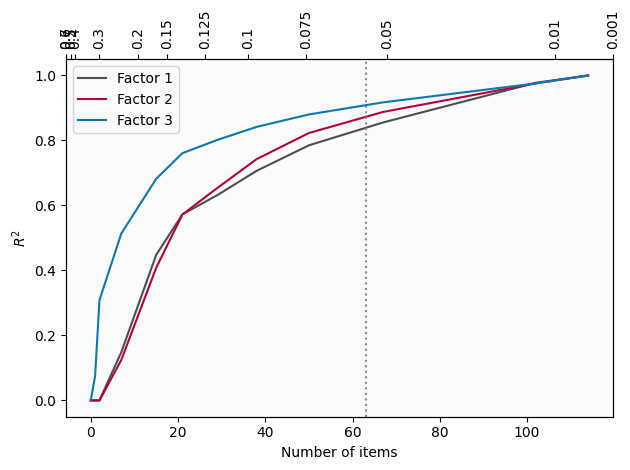

In [17]:
f, ax = plt.subplots(dpi=100, facecolor='white')
for i in range(3):
    ax.plot(n_items, r2_values[i, :], label='Factor {0}'.format(i+1), color=pal[i])
ax.set_xlabel("Number of items")
ax.set_ylabel("$R^2$")
ax.legend()
ax2 = ax.twiny()
ax2.set_xticklabels(alpha_values)
ax2.set_xticks(n_items)
ax.axvline(63, color='#8c8a8a', linestyle=':')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()

# plt.savefig('../figures/number_of_questions.svg')

In [18]:
clf = Lasso(alpha=0.125)
pred = cross_val_predict(clf, qns.iloc[:, 2:], scores.iloc[:, 2:], cv=5)
clf.fit(qns.iloc[:, 2:], scores.iloc[:, 2:]);

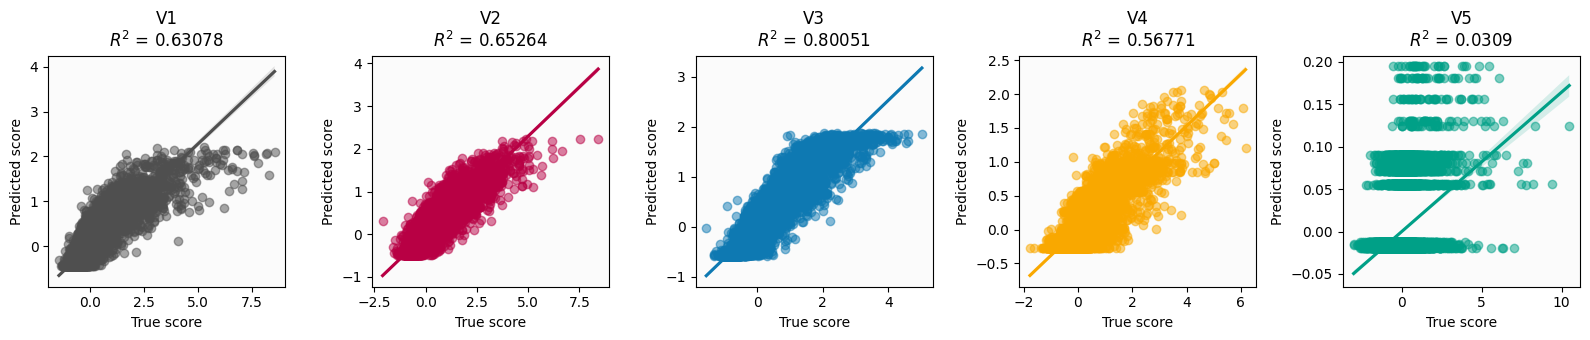

In [19]:
f, ax = plt.subplots(1, 5, figsize=(16, 3.5), dpi=100, facecolor='white')

factors = ['V1', 'V2', 'V3','V4' ,'V5']

for i in range(5):
    sns.regplot(x = scores.iloc[:, i+2], y =  pred[:, i], ax=ax[i], color=pal[i], scatter_kws={'alpha': 0.5})
    ax[i].set_title(factors[i] + '\n$R^2$ = {0}'.format(np.round(r2_score(scores.iloc[:, i+2], pred[:, i]), 5)), fontweight='light')
    ax[i].set_xlabel('True score')
    ax[i].set_ylabel('Predicted score')
    
plt.tight_layout()
# plt.savefig('../figures/factor_prediction.svg')

Text(83.22222222222221, 0.5, 'Factor')

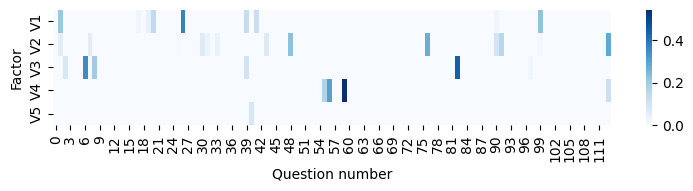

In [20]:
plt.figure(dpi=100, figsize=(9, 1.5), facecolor='white')
sns.heatmap(clf.coef_, cmap='Blues', yticklabels=['V1', 'V2', 'V3', 'V4', 'V5'])
plt.xlabel("Question number")
plt.ylabel("Factor")
# plt.savefig('../figures/all_question_coefs.svg')

In [21]:
np.any(clf.coef_.T != 0, axis=1).sum()


29

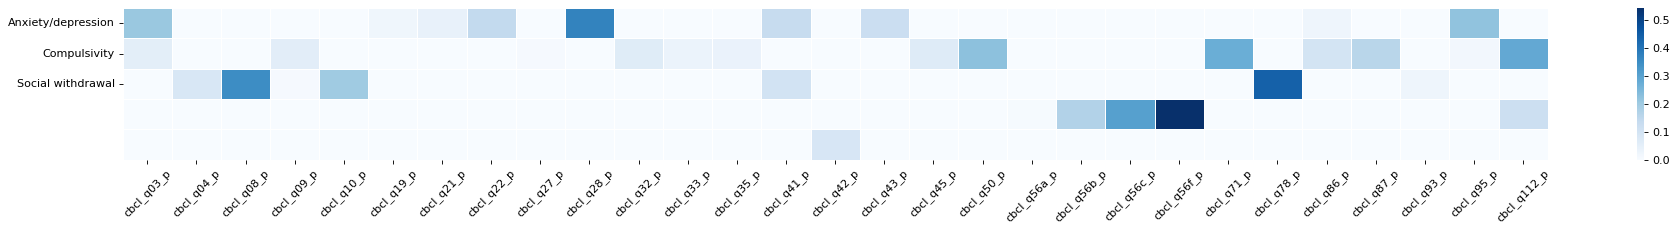

In [22]:
plt.figure(figsize=(24, 3), dpi=80, facecolor='white')
coefs = clf.coef_.T
sns.heatmap(coefs[np.any(coefs != 0, axis=1)].T, cmap="Blues", xticklabels=qns.columns[2:][np.any(coefs != 0, axis=1)],
           yticklabels=['Anxiety/depression', 'Compulsivity', 'Social withdrawal'], linewidths=.5);
plt.xticks(rotation=45);
plt.tight_layout()
# plt.savefig('../figures/retained_questions.svg')

# sparse autoencoder

In [124]:
qns.iloc[:, 2:]

,cbcl_q01_p,cbcl_q03_p,cbcl_q04_p,cbcl_q05_p,cbcl_q06_p,cbcl_q07_p,cbcl_q08_p,cbcl_q09_p,cbcl_q10_p,cbcl_q11_p,...,cbcl_q102_p,cbcl_q103_p,cbcl_q104_p,cbcl_q106_p,cbcl_q107_p,cbcl_q108_p,cbcl_q109_p,cbcl_q110_p,cbcl_q111_p,cbcl_q112_p
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8942,0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
8943,1,1,1,0,0,0,1,0,1,1,...,1,1,0,0,0,0,1,0,0,1
8944,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
8945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,ActivityRegularization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Data Normalization
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(qns.iloc[:, 2:])

# 2. Define a Simplified Autoencoder Structure
input_dim = qns.iloc[:, 2:].shape[1]
encoding_dim = 5  # Capturing five main features

# Input Layer
input_layer = Input(shape=(input_dim,))

# Encoding Layer
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = ActivityRegularization(l1=1e-4)(encoded)

# Decoding Layer
decoded = Dense(input_dim, activation='linear')(encoded)

# Construct Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder Model (to extract features)
encoder = Model(inputs=input_layer, outputs=encoded)

# 3. Compile and Train the Model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
autoencoder.fit(data_scaled, data_scaled, epochs=200, batch_size=32, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

# 4. Extract Main Components
encoded_data = encoder.predict(data_scaled)

# Convert the extracted components to a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=[f'PC{i+1}' for i in range(encoding_dim)])

# View the extracted components
print(encoded_df.head())


Epoch 1/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0509 - mae: 0.1158 - val_loss: 0.0328 - val_mae: 0.1147
Epoch 2/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.0361 - mae: 0.1183 - val_loss: 0.0308 - val_mae: 0.1029
Epoch 3/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0347 - mae: 0.1109 - val_loss: 0.0304 - val_mae: 0.1009
Epoch 4/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0342 - mae: 0.1094 - val_loss: 0.0303 - val_mae: 0.0999
Epoch 5/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0341 - mae: 0.1087 - val_loss: 0.0302 - val_mae: 0.1003
Epoch 6/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0347 - mae: 0.1105 - val_loss: 0.0301 - val_mae: 0.1005
Epoch 7/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0341 - mae: 0.1095 - val_loss: 0.0301 - val_mae: 0.1006
Epoch 8/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0338 - mae: 0.1088 - val_loss: 0.0299 - val_mae: 0.0997
Epoch 9/200
224/224 ━━━━━━━━━━━━━━

In [126]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 用训练好的Autoencoder对原始数据进行重构
reconstructed_data = autoencoder.predict(data_scaled)

# 计算每个特征的总方差
total_variance = np.var(data_scaled, axis=0)

# 计算重构误差 (MSE)
reconstruction_error = mean_squared_error(data_scaled, reconstructed_data)

# 计算解释的方差比例
variance_explained_total = 1 - (reconstruction_error / np.mean(total_variance))

print(f'Variance Explained: {variance_explained_total:.4f}')


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
Variance Explained: 0.3426


In [127]:
encoded_df

,PC1,PC2,PC3,PC4,PC5
0,0.004024,0.033268,0.015003,0.054835,0.008215
1,0.036652,0.026473,0.000000,0.000000,0.000000
2,0.036495,0.000000,0.000000,0.000839,0.000000
3,0.046388,0.014393,0.054044,0.036450,0.038265
4,0.000000,0.052144,0.009681,0.081652,0.000000
...,...,...,...,...,...
8942,0.007805,0.070670,0.006713,0.008951,0.069377
8943,0.077333,0.092783,0.116401,0.076105,0.105912
8944,0.057946,0.034327,0.000000,0.012800,0.038471
8945,0.010644,0.003564,0.000000,0.001124,0.004877


# RF

In [24]:

# load data and drop the first column and the subject id
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_aseg.csv")
# only keep eventname = baseline_year_1_arm_1
data = data[data['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname'])

labels = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\nmf_W.csv').iloc[:, 1:]

# only keep the subjects that have labels
data = data[data['src_subject_id'].isin(labels["src_subject_id"])]

In [349]:
data.drop(columns=['src_subject_id'], inplace=True)
labels.drop(columns=['src_subject_id'], inplace=True)

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_6936\3108171495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['src_subject_id'], inplace=True)


In [369]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
#import pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        # n_estimators=params['n_estimators'],
        # max_depth=params['max_depth'],
        # min_samples_split=params['min_samples_split'],
        # min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    ))
])

# Perform 10-fold cross-validation
cv_scores = cross_val_score(pipeline, data, labels, cv=2, scoring='r2')

# Report the mean R2 score from cross-validation to NNI
mean_cv_r2 = cv_scores.mean()


# Print cross-validation scores
print(f'10-Fold Cross-Validation R2 Scores: {cv_scores}')
print(f'Mean R2 Score from 10-Fold Cross-Validation: {mean_cv_r2}')

KeyboardInterrupt: 

In [372]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np

# 创建一个函数来构建神经网络模型
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 一次性划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 数据归一化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建和编译模型
model = create_nn_model(input_dim=X_train.shape[1])

# 定义 EarlyStopping 回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# 训练模型并使用 EarlyStopping
model.fit(
    X_train_scaled, 
    y_train, 
    validation_data=(X_test_scaled, y_test),  # 添加验证数据以监控 val_loss
    epochs=100, 
    batch_size=10, 
    verbose=2, 
    callbacks=[early_stopping]  # 添加 EarlyStopping 回调
)

# 进行预测
y_pred = model.predict(X_test_scaled)

# 计算 R^2 分数
score = r2_score(y_test, y_pred)

# 输出 R^2 分数
print("R^2 score:", score)


Epoch 1/100


c:\Anaconda\envs\Tensorflow\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


853/853 - 1s - 2ms/step - loss: 0.9912 - mae: 0.7254 - val_loss: 0.9704 - val_mae: 0.6975
Epoch 2/100
853/853 - 1s - 799us/step - loss: 0.8245 - mae: 0.6764 - val_loss: 0.9641 - val_mae: 0.7336
Epoch 3/100
853/853 - 1s - 869us/step - loss: 0.7642 - mae: 0.6519 - val_loss: 1.0132 - val_mae: 0.7600
Epoch 4/100
853/853 - 1s - 800us/step - loss: 0.7115 - mae: 0.6328 - val_loss: 1.0228 - val_mae: 0.7254
Epoch 5/100
853/853 - 1s - 953us/step - loss: 0.6598 - mae: 0.6079 - val_loss: 1.0440 - val_mae: 0.7672
Epoch 6/100
853/853 - 1s - 884us/step - loss: 0.5991 - mae: 0.5819 - val_loss: 1.0900 - val_mae: 0.7710
Epoch 7/100
853/853 - 1s - 875us/step - loss: 0.5474 - mae: 0.5530 - val_loss: 1.1460 - val_mae: 0.7898
Epoch 8/100
853/853 - 1s - 882us/step - loss: 0.4990 - mae: 0.5268 - val_loss: 1.2186 - val_mae: 0.8249
Epoch 9/100
853/853 - 1s - 907us/step - loss: 0.4727 - mae: 0.5089 - val_loss: 1.2220 - val_mae: 0.8153
Epoch 10/100
853/853 - 1s - 891us/step - loss: 0.4323 - mae: 0.4862 - val_loss

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# load data and drop the first column and the subject id
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_aseg.csv")
# only keep eventname = baseline_year_1_arm_1
data = data[data['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname']).dropna()

labels = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\EFA.csv').iloc[:, 1:]
# labels = pd.read_csv(r'G:/ABCD/data/mh_p_cbcl.csv')
# # only keep the  column.('cbcl_scr_syn_anxdep_t')
# labels = labels[labels['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname'])
# labels = labels[['src_subject_id', 'cbcl_scr_syn_anxdep_t']].dropna()

# only keep the subjects that have labels
data = data[data['src_subject_id'].isin(labels["src_subject_id"])]

In [63]:
labels

,src_subject_id,PA1,PA2,PA3,PA5,PA4
0,NDAR_INV003RTV85,-0.590732,-0.675405,-0.734731,-0.707320,0.474278
1,NDAR_INV005V6D2C,-0.463630,-0.569176,-0.943524,-0.853836,0.226067
2,NDAR_INV007W6H7B,-0.561360,0.088093,0.267510,1.555214,0.320209
3,NDAR_INV00BD7VDC,-0.393168,0.241235,0.337544,-0.462533,-0.893611
4,NDAR_INV00CY2MDM,2.441081,0.258618,0.827516,-1.152136,-1.017326
...,...,...,...,...,...,...
10647,NDAR_INVZZLZCKAY,0.704346,2.204722,1.285274,1.950706,1.057855
10648,NDAR_INVZZNX6W2P,0.570672,0.403511,-0.676810,-0.893910,-0.799992
10649,NDAR_INVZZPKBDAC,-0.555718,-0.763623,-0.856959,-0.452341,0.132974
10650,NDAR_INVZZZ2ALR6,-0.232042,0.089243,-0.821274,-0.141745,-0.697024


In [42]:
data

,src_subject_id,rsfmri_cor_ngd_au_scs_aalh,rsfmri_cor_ngd_au_scs_aarh,rsfmri_cor_ngd_au_scs_aglh,rsfmri_cor_ngd_au_scs_agrh,rsfmri_cor_ngd_au_scs_bs,rsfmri_cor_ngd_au_scs_cdelh,rsfmri_cor_ngd_au_scs_cderh,rsfmri_cor_ngd_au_scs_crcxlh,rsfmri_cor_ngd_au_scs_crcxrh,...,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_pllh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_ptlh,rsfmri_cor_ngd_vs_scs_ptrh,rsfmri_cor_ngd_vs_scs_thplh,rsfmri_cor_ngd_vs_scs_thprh,rsfmri_cor_ngd_vs_scs_vtdclh,rsfmri_cor_ngd_vs_scs_vtdcrh
0,NDAR_INV003RTV85,-0.090258,-0.083909,0.004247,-0.054861,-0.048167,0.036012,0.013843,-0.020096,-0.081816,...,0.106619,0.112692,0.013191,-0.106608,0.074385,0.119522,-0.135962,-0.060436,-0.000929,0.113327
1,NDAR_INV005V6D2C,-0.098593,0.093085,-0.170801,-0.134319,-0.022124,0.092985,0.061854,0.011913,0.013176,...,-0.026733,-0.061707,0.127464,-0.135847,0.097308,0.104559,-0.060583,-0.037027,0.021549,-0.014602
2,NDAR_INV007W6H7B,-0.065449,0.122893,-0.006246,-0.118878,-0.027118,-0.026523,-0.045971,-0.065351,-0.036497,...,0.076594,0.110142,-0.077766,-0.020942,0.120677,0.135012,0.020034,-0.017153,-0.043255,-0.072356
3,NDAR_INV00BD7VDC,-0.148170,-0.049085,-0.026814,-0.028232,0.008625,-0.153769,-0.073198,-0.138927,0.032385,...,0.099686,0.077307,0.019302,0.064816,0.141727,0.010190,-0.038964,0.030539,-0.019395,-0.060836
6,NDAR_INV00CY2MDM,-0.148117,0.037320,-0.104190,-0.037308,0.121178,0.034533,-0.183537,-0.258663,0.003149,...,-0.036267,-0.058694,-0.152607,-0.076361,0.058996,0.226045,-0.028446,-0.064175,-0.066788,0.010962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,NDAR_INVZZLZCKAY,0.030591,0.003116,-0.138875,-0.096117,-0.008607,-0.111538,-0.111535,-0.161508,-0.102951,...,0.097498,0.043633,0.055380,0.102299,0.149435,0.025411,-0.097254,0.030673,-0.084058,-0.002552
22120,NDAR_INVZZNX6W2P,-0.089590,-0.002218,-0.150480,0.052007,0.119924,-0.258660,-0.164504,-0.068733,-0.057475,...,0.016435,0.048579,0.084433,-0.091015,0.185989,0.038151,0.006236,0.012520,0.060238,-0.132834
22123,NDAR_INVZZPKBDAC,-0.112247,-0.010195,0.038551,-0.112359,-0.043313,0.045530,-0.188547,-0.048601,-0.165866,...,-0.023279,0.049299,0.093359,-0.069631,0.228659,0.213006,-0.077175,-0.049607,0.041590,-0.035196
22125,NDAR_INVZZZ2ALR6,0.051633,-0.127992,-0.172488,0.013249,-0.014129,-0.236400,-0.056846,0.076282,-0.055248,...,0.062011,-0.025998,0.016382,-0.024677,0.084724,0.093898,0.000896,-0.202033,0.027023,0.074749


In [ ]:
data = data.drop(columns=['src_subject_id'])
labels = labels.drop(columns=['src_subject_id'])

In [69]:
labels.iloc[:,[1]]

,PA2
0,-0.675405
1,-0.569176
2,0.088093
3,0.241235
4,0.258618
...,...
10647,2.204722
10648,0.403511
10649,-0.763623
10650,0.089243


In [ ]:
# linear regression
#import train_test_split
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(data, labels.iloc[:,[1]], test_size=0.3, random_state=42)

# 使用支持向量回归
regressor = svm.SVR()  # 确保使用 SVR 而不是 SVC
regressor.fit(X_train, y_train)

# 预测
y_pred = regressor.predict(X_test)
# accuracy 
# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("均方误差 (MSE):", mse)
print("R^2 评分:", r2)


c:\Anaconda\envs\Tensorflow\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: -0.09530539862210774
均方误差 (MSE): 0.9913688966571422
R^2 评分: -0.09530539862210774


In [36]:
labels = labels.drop(columns=['src_subject_id'])

In [42]:
# 导入必要的库
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 将数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels.iloc[:, [0]], test_size=0.2)

# 使用线性回归
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# 预测
y_pred = regressor.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("均方误差 (MSE):", mse)
print("R^2 评分:", r2)


均方误差 (MSE): 0.9943679438196448
R^2 评分: -0.01415056228921241


In [51]:
# 导入必要的库
from sklearn.model_selection import train_test_split
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import f1_score

# 将数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

# 使用线性回归
regressor1 = MultiTaskElasticNet()
regressor1.fit(X_train, y_train)

# 预测
y_pred = regressor1.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("均方误差 (MSE):", mse)
print("R^2 评分:", r2)


均方误差 (MSE): 0.8409004247621553
R^2 评分: -0.00017185603033462727


In [27]:
target = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\data_cleaned.csv').drop(columns=['Unnamed: 0', 'src_subject_id'])

In [53]:
target.to_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\target.csv', index=False)

In [ ]:
# data.to_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\data.csv', index=False)

In [38]:
target = latent_df

In [52]:
target

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,0.225962,-0.987701,1.428785,0.196275,2.294005
1,-0.270909,-1.172184,1.699451,1.889652,2.205972
2,-0.170160,0.610330,-0.446073,2.320928,1.705356
3,0.410402,-0.158501,0.223055,3.264879,1.840801
4,3.462913,-5.130525,1.558750,5.146125,-4.048456
...,...,...,...,...,...
10647,-6.752625,5.188299,0.805525,-0.362465,-2.794127
10648,0.047847,-2.206021,1.290669,3.946332,-0.416121
10649,-0.721727,-0.715168,1.275204,0.842071,2.017429
10650,-0.617627,-1.584424,0.179293,1.639837,0.536771


In [49]:
data = data.drop(columns=['src_subject_id'])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data, target.iloc[:,1], test_size=0.2)

In [55]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

#标准化数据
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model1 = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("均方误差 (MSE):", mse)
print("R^2 评分:", r2)


均方误差 (MSE): 12.757518307536543
R^2 评分: -0.5547964281276063


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np

# 创建一个函数来构建神经网络模型
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# 准备数据
X_train, X_test, y_train, y_test = train_test_split(data, target.iloc[:, 1], test_size=0.2, random_state=42)

# 数据归一化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# 创建模型
input_dim = X_train.shape[1]
model = NeuralNetwork(input_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early Stopping 参数
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    
    # 验证阶段
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        val_loss = criterion(y_pred, y_test_tensor).item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # 检查 Early Stopping 条件
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 预测和计算 R² 分数
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

score = r2_score(y_test, y_pred)
print("R² score:", score)


Epoch [1/100], Train Loss: 6.9431, Val Loss: 4.8581
Epoch [2/100], Train Loss: 6.7767, Val Loss: 4.9208
Epoch [3/100], Train Loss: 6.6072, Val Loss: 4.9533
Epoch [4/100], Train Loss: 6.3278, Val Loss: 5.1843
Epoch [5/100], Train Loss: 5.8956, Val Loss: 5.3937
Epoch [6/100], Train Loss: 5.3739, Val Loss: 5.6553
Epoch [7/100], Train Loss: 4.7916, Val Loss: 5.7848
Epoch [8/100], Train Loss: 4.2999, Val Loss: 6.0064
Epoch [9/100], Train Loss: 3.7938, Val Loss: 5.7991
Epoch [10/100], Train Loss: 3.3754, Val Loss: 6.0572
Epoch [11/100], Train Loss: 3.0624, Val Loss: 6.4718
Early stopping at epoch 11
R² score: -0.3518291493573309


In [56]:
from sklearn.linear_model import MultiTaskElasticNet


model = MultiTaskElasticNet()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("均方误差 (MSE):", mse)
print("R^2 评分:", r2)


ValueError: For mono-task outputs, use ElasticNet

# Fit the model with scores

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# load data and drop the first column and the subject id
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_aseg.csv")
# only keep eventname = baseline_year_1_arm_1
data = data[data['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname']).dropna()

# labels = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\EFA.csv').iloc[:, 1:]
labels = pd.read_csv(r'G:/ABCD/data/mh_p_cbcl.csv')
# only keep the  column.('cbcl_scr_syn_anxdep_t')
labels = labels[labels['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname'])
labels = labels[['src_subject_id', 'cbcl_scr_syn_anxdep_t']].dropna()

# only keep the subjects that have labels
data = data[data['src_subject_id'].isin(labels["src_subject_id"])]
labels = labels[labels['src_subject_id'].isin(data["src_subject_id"])]

data = data.drop(columns=['src_subject_id'])
labels = labels.drop(columns=['src_subject_id'])

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5408\2238401008.py:10: DtypeWarning: Columns (124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv(r'G:/ABCD/data/mh_p_cbcl.csv')


In [2]:
labels

,cbcl_scr_syn_anxdep_t
0,50.0
4,50.0
8,53.0
11,59.0
14,53.0
...,...
48710,65.0
48715,51.0
48720,50.0
48725,52.0


In [3]:
data

,rsfmri_cor_ngd_au_scs_aalh,rsfmri_cor_ngd_au_scs_aarh,rsfmri_cor_ngd_au_scs_aglh,rsfmri_cor_ngd_au_scs_agrh,rsfmri_cor_ngd_au_scs_bs,rsfmri_cor_ngd_au_scs_cdelh,rsfmri_cor_ngd_au_scs_cderh,rsfmri_cor_ngd_au_scs_crcxlh,rsfmri_cor_ngd_au_scs_crcxrh,rsfmri_cor_ngd_au_scs_hplh,...,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_pllh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_ptlh,rsfmri_cor_ngd_vs_scs_ptrh,rsfmri_cor_ngd_vs_scs_thplh,rsfmri_cor_ngd_vs_scs_thprh,rsfmri_cor_ngd_vs_scs_vtdclh,rsfmri_cor_ngd_vs_scs_vtdcrh
0,-0.090258,-0.083909,0.004247,-0.054861,-0.048167,0.036012,0.013843,-0.020096,-0.081816,-0.043832,...,0.106619,0.112692,0.013191,-0.106608,0.074385,0.119522,-0.135962,-0.060436,-0.000929,0.113327
1,-0.098593,0.093085,-0.170801,-0.134319,-0.022124,0.092985,0.061854,0.011913,0.013176,-0.010548,...,-0.026733,-0.061707,0.127464,-0.135847,0.097308,0.104559,-0.060583,-0.037027,0.021549,-0.014602
2,-0.065449,0.122893,-0.006246,-0.118878,-0.027118,-0.026523,-0.045971,-0.065351,-0.036497,-0.085342,...,0.076594,0.110142,-0.077766,-0.020942,0.120677,0.135012,0.020034,-0.017153,-0.043255,-0.072356
3,-0.148170,-0.049085,-0.026814,-0.028232,0.008625,-0.153769,-0.073198,-0.138927,0.032385,-0.063008,...,0.099686,0.077307,0.019302,0.064816,0.141727,0.010190,-0.038964,0.030539,-0.019395,-0.060836
6,-0.148117,0.037320,-0.104190,-0.037308,0.121178,0.034533,-0.183537,-0.258663,0.003149,-0.051349,...,-0.036267,-0.058694,-0.152607,-0.076361,0.058996,0.226045,-0.028446,-0.064175,-0.066788,0.010962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.030591,0.003116,-0.138875,-0.096117,-0.008607,-0.111538,-0.111535,-0.161508,-0.102951,-0.041270,...,0.097498,0.043633,0.055380,0.102299,0.149435,0.025411,-0.097254,0.030673,-0.084058,-0.002552
22120,-0.089590,-0.002218,-0.150480,0.052007,0.119924,-0.258660,-0.164504,-0.068733,-0.057475,-0.058599,...,0.016435,0.048579,0.084433,-0.091015,0.185989,0.038151,0.006236,0.012520,0.060238,-0.132834
22123,-0.112247,-0.010195,0.038551,-0.112359,-0.043313,0.045530,-0.188547,-0.048601,-0.165866,-0.003135,...,-0.023279,0.049299,0.093359,-0.069631,0.228659,0.213006,-0.077175,-0.049607,0.041590,-0.035196
22125,0.051633,-0.127992,-0.172488,0.013249,-0.014129,-0.236400,-0.056846,0.076282,-0.055248,-0.004072,...,0.062011,-0.025998,0.016382,-0.024677,0.084724,0.093898,0.000896,-0.202033,0.027023,0.074749


In [70]:
# 使用条件语句将 'cbcl_scr_syn_anxdep_t' 列的值重新分类
labels['cbcl_scr_syn_anxdep_t'] = labels['cbcl_scr_syn_anxdep_t'].apply(
    lambda x: 0 if x <= 50 else (1 if x <= 64 else 2)
)


In [71]:
data

,rsfmri_cor_ngd_au_scs_aalh,rsfmri_cor_ngd_au_scs_aarh,rsfmri_cor_ngd_au_scs_aglh,rsfmri_cor_ngd_au_scs_agrh,rsfmri_cor_ngd_au_scs_bs,rsfmri_cor_ngd_au_scs_cdelh,rsfmri_cor_ngd_au_scs_cderh,rsfmri_cor_ngd_au_scs_crcxlh,rsfmri_cor_ngd_au_scs_crcxrh,rsfmri_cor_ngd_au_scs_hplh,...,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_pllh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_ptlh,rsfmri_cor_ngd_vs_scs_ptrh,rsfmri_cor_ngd_vs_scs_thplh,rsfmri_cor_ngd_vs_scs_thprh,rsfmri_cor_ngd_vs_scs_vtdclh,rsfmri_cor_ngd_vs_scs_vtdcrh
0,-0.090258,-0.083909,0.004247,-0.054861,-0.048167,0.036012,0.013843,-0.020096,-0.081816,-0.043832,...,0.106619,0.112692,0.013191,-0.106608,0.074385,0.119522,-0.135962,-0.060436,-0.000929,0.113327
1,-0.098593,0.093085,-0.170801,-0.134319,-0.022124,0.092985,0.061854,0.011913,0.013176,-0.010548,...,-0.026733,-0.061707,0.127464,-0.135847,0.097308,0.104559,-0.060583,-0.037027,0.021549,-0.014602
2,-0.065449,0.122893,-0.006246,-0.118878,-0.027118,-0.026523,-0.045971,-0.065351,-0.036497,-0.085342,...,0.076594,0.110142,-0.077766,-0.020942,0.120677,0.135012,0.020034,-0.017153,-0.043255,-0.072356
3,-0.148170,-0.049085,-0.026814,-0.028232,0.008625,-0.153769,-0.073198,-0.138927,0.032385,-0.063008,...,0.099686,0.077307,0.019302,0.064816,0.141727,0.010190,-0.038964,0.030539,-0.019395,-0.060836
6,-0.148117,0.037320,-0.104190,-0.037308,0.121178,0.034533,-0.183537,-0.258663,0.003149,-0.051349,...,-0.036267,-0.058694,-0.152607,-0.076361,0.058996,0.226045,-0.028446,-0.064175,-0.066788,0.010962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.030591,0.003116,-0.138875,-0.096117,-0.008607,-0.111538,-0.111535,-0.161508,-0.102951,-0.041270,...,0.097498,0.043633,0.055380,0.102299,0.149435,0.025411,-0.097254,0.030673,-0.084058,-0.002552
22120,-0.089590,-0.002218,-0.150480,0.052007,0.119924,-0.258660,-0.164504,-0.068733,-0.057475,-0.058599,...,0.016435,0.048579,0.084433,-0.091015,0.185989,0.038151,0.006236,0.012520,0.060238,-0.132834
22123,-0.112247,-0.010195,0.038551,-0.112359,-0.043313,0.045530,-0.188547,-0.048601,-0.165866,-0.003135,...,-0.023279,0.049299,0.093359,-0.069631,0.228659,0.213006,-0.077175,-0.049607,0.041590,-0.035196
22125,0.051633,-0.127992,-0.172488,0.013249,-0.014129,-0.236400,-0.056846,0.076282,-0.055248,-0.004072,...,0.062011,-0.025998,0.016382,-0.024677,0.084724,0.093898,0.000896,-0.202033,0.027023,0.074749


## autoencoder

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import numpy as np
import matplotlib.colors as mcolors

In [5]:
RANDOM_SEED = 49
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 30
NUM_CLASSES = 10

In [ ]:
import torch
import torch.nn as nn

class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)
class Trim(nn.Module):
    def forward(self, x):
        return x[:, :, :28, :28]  # 裁剪到指定尺寸


In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3),     padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, 2)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


NameError: name 'Reshape' is not defined

In [ ]:
def train_autoencoder(num_epochs, model, optimizer,
                         train_loader, loss_fn=None,
                         logging_interval=100,
                         skip_epoch_stats=False,
                         save_model=None):
    log_dict = {'train_loss_per_batch': [],
                'train_loss_per_epoch': []}
    if loss_fn is None:
        loss_fn = F.mse_loss
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):
            # FORWARD AND BACK PROP
            logits = model(features)
            loss = loss_fn(logits, features)
            optimizer.zero_grad()
            loss.backward()
            # UPDATE MODEL PARAMETERS
            optimizer.step()
            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))
        if not skip_epoch_stats:
            model.eval()
            with torch.set_grad_enabled(False):  # save memory during inference
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    return log_dict
log_dict = train_autoencoder(num_epochs=NUM_EPOCHS, model=model,
                                optimizer=optimizer,
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

## others

In [140]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 将数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels.iloc[:, [0]], test_size=0.2)

# 将标签转换为 numpy 数组并进行形状调整
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 构建神经网络模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # 输出层，回归问题使用线性激活
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# 训练模型
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

# 预测
y_pred = model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("均方误差 (MSE):", mse)
print("R^2 评分:", r2)


Epoch 1/200


c:\Anaconda\envs\Tensorflow\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4610 - mse: 0.4610 - val_loss: 0.4071 - val_mse: 0.4073
Epoch 2/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.3982 - mse: 0.3982 - val_loss: 0.3991 - val_mse: 0.3993
Epoch 3/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 0.3918 - mse: 0.3918 - val_loss: 0.3970 - val_mse: 0.3973
Epoch 4/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.4005 - mse: 0.4005 - val_loss: 0.3968 - val_mse: 0.3970
Epoch 5/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.3983 - mse: 0.3983 - val_loss: 0.3991 - val_mse: 0.3993
Epoch 6/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.4041 - mse: 0.4041 - val_loss: 0.3976 - val_mse: 0.3978
Epoch 7/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.4005 - mse: 0.4005 - val_loss: 0.3992 - val_mse: 0.3994
Epoch 8/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.3882 - mse: 0.3882 - val_loss: 0.4004 - val_mse: 0.4006
Epoch 9/200
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 86

KeyboardInterrupt: 

In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 定义一个 MLP Block
def MLPBlock(units, dropout_rate):
    return keras.Sequential([
        layers.Dense(units, activation='relu'),  # 线性层 + ReLU 激活函数
        layers.Dropout(dropout_rate)             # Dropout 层
    ])

# 构建完整的 MLP 模型
def build_mlp_model(input_shape, num_blocks, units_per_block, dropout_rate):
    inputs = keras.Input(shape=(input_shape,))
    x = inputs

    # 堆叠多个 MLP Block
    for _ in range(num_blocks):
        x = MLPBlock(units_per_block, dropout_rate)(x)

    # 输出层，三分类问题使用 softmax 激活函数
        outputs = layers.Dense(200)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# 示例：构建模型
input_shape = 247  # 输入特征数
num_blocks = 3  # 堆叠 3 个 MLP Block
units_per_block = 64  # 每个 MLP Block 的神经元数
dropout_rate = 0.3  # Dropout 概率

model = build_mlp_model(input_shape, num_blocks, units_per_block, dropout_rate)

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# 查看模型结构
model.summary()


Model: "functional_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_133 (InputLayer)    │ (None, 247)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_114 (Sequential)     │ (None, 64)             │        15,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_115 (Sequential)     │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_116 (Sequential)     │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 200)            │        13,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,192 (145.28 KB)

 Trainable params: 37,192 (145.28 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
#import standard scaler
from sklearn.preprocessing import StandardScaler
# 假设你有 X_train, y_train, X_test, y_test 数据
# 将数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels.iloc[:, [0]], test_size=0.2)

# 将标签转换为 numpy 数组并进行形状调整
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4079 - loss: 2.1209 - val_accuracy: 0.5067 - val_loss: 0.9556
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4990 - loss: 1.0486 - val_accuracy: 0.5040 - val_loss: 0.9487
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4990 - loss: 1.0095 - val_accuracy: 0.5036 - val_loss: 0.9284
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4969 - loss: 0.9802 - val_accuracy: 0.5067 - val_loss: 0.9128
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5005 - loss: 0.9694 - val_accuracy: 0.5067 - val_loss: 0.9081
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4941 - loss: 0.9564 - val_accuracy: 0.5067 - val_loss: 0.9065
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4952 - loss: 0.9262 - val_accuracy: 0.5067 - val_loss: 0.9060
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5083 - loss: 0.9273 - val_accuracy: 0.

In [56]:
#calculate the accuracy
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


ValueError: Classification metrics can't handle a mix of continuous and binary targets

# autoencoder by previous research

In [4]:
import pandas as pd

In [5]:
qns = pd.read_csv(r'G:\ABCD\script\trail/trail_tsne_RF/factor analysis/output/NA/data_cleaned.csv')

In [6]:
qns.iloc[:,2:]

,cbcl_q01_p,cbcl_q03_p,cbcl_q04_p,cbcl_q05_p,cbcl_q06_p,cbcl_q07_p,cbcl_q08_p,cbcl_q09_p,cbcl_q10_p,cbcl_q11_p,...,cbcl_q102_p,cbcl_q103_p,cbcl_q104_p,cbcl_q106_p,cbcl_q107_p,cbcl_q108_p,cbcl_q109_p,cbcl_q110_p,cbcl_q111_p,cbcl_q112_p
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
3,0,1,1,0,0,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,1
4,1,2,1,0,0,1,2,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10647,0,2,1,0,0,0,1,1,1,0,...,1,0,1,0,0,0,1,0,1,1
10648,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
10649,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10650,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = qns.iloc[:,2:].values

In [8]:
X.shape

(10652, 114)

In [9]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Assuming your questionnaire items are in columns named 'Q1' to 'Q100'
# questionnaire_columns = [col for col in data.columns if col.startswith('Q')]
X = qns.iloc[:,2:].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Create PyTorch datasets and dataloaders
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same

train_dataset = QuestionnaireDataset(X_train)
val_dataset = QuestionnaireDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 2: Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = X_train.shape[1]
latent_dim = 5  # Reduce to 5 dimensions

model = Autoencoder(input_dim, latent_dim)

# Step 3: Train the autoencoder
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0


for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, _ in val_loader:
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss.item() * batch_features.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


    # 检查 Early Stopping 条件
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # 重置计数器
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break
# Step 4: Extract the latent features
model.eval()
with torch.no_grad():
    # Transform the entire dataset
    X_latent = model.encoder(torch.tensor(X_scaled, dtype=torch.float32)).numpy()

# The variable X_latent now contains the 5-dimensional representation of your data
# You can convert it back to a DataFrame if needed
latent_df = pd.DataFrame(X_latent, columns=[f'Factor_{i+1}' for i in range(latent_dim)])


Epoch [1/200], Train Loss: 0.8461, Val Loss: 0.7685
Epoch [2/200], Train Loss: 0.7573, Val Loss: 0.7251
Epoch [3/200], Train Loss: 0.7290, Val Loss: 0.7128
Epoch [4/200], Train Loss: 0.7160, Val Loss: 0.7047
Epoch [5/200], Train Loss: 0.7053, Val Loss: 0.6990
Epoch [6/200], Train Loss: 0.6975, Val Loss: 0.6946
Epoch [7/200], Train Loss: 0.6913, Val Loss: 0.6919
Epoch [8/200], Train Loss: 0.6859, Val Loss: 0.6882
Epoch [9/200], Train Loss: 0.6816, Val Loss: 0.6864
Epoch [10/200], Train Loss: 0.6769, Val Loss: 0.6828
Epoch [11/200], Train Loss: 0.6730, Val Loss: 0.6806
Epoch [12/200], Train Loss: 0.6702, Val Loss: 0.6794
Epoch [13/200], Train Loss: 0.6676, Val Loss: 0.6772
Epoch [14/200], Train Loss: 0.6645, Val Loss: 0.6777
Epoch [15/200], Train Loss: 0.6623, Val Loss: 0.6757
Epoch [16/200], Train Loss: 0.6599, Val Loss: 0.6751
Epoch [17/200], Train Loss: 0.6570, Val Loss: 0.6739
Epoch [18/200], Train Loss: 0.6546, Val Loss: 0.6741
Epoch [19/200], Train Loss: 0.6526, Val Loss: 0.6715
Ep

In [35]:
latent_df

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,0.225962,-0.987701,1.428785,0.196275,2.294005
1,-0.270909,-1.172184,1.699451,1.889652,2.205972
2,-0.170160,0.610330,-0.446073,2.320928,1.705356
3,0.410402,-0.158501,0.223055,3.264879,1.840801
4,3.462913,-5.130525,1.558750,5.146125,-4.048456
...,...,...,...,...,...
10647,-6.752625,5.188299,0.805525,-0.362465,-2.794127
10648,0.047847,-2.206021,1.290669,3.946332,-0.416121
10649,-0.721727,-0.715168,1.275204,0.842071,2.017429
10650,-0.617627,-1.584424,0.179293,1.639837,0.536771


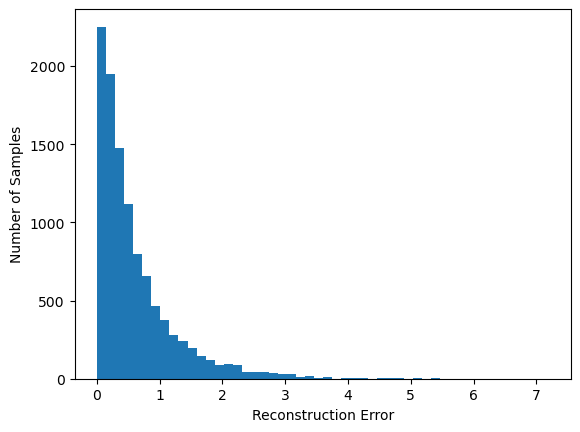

In [11]:
import matplotlib.pyplot as plt

# Compute reconstruction error for each sample
model.eval()
with torch.no_grad():
    reconstructed = model(torch.tensor(X_scaled, dtype=torch.float32))
    mse = nn.MSELoss(reduction='none')
    reconstruction_error = mse(reconstructed, torch.tensor(X_scaled, dtype=torch.float32)).mean(dim=1).numpy()

plt.hist(reconstruction_error, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.show()


In [ ]:
import numpy as np

# 原始数据的总方差
total_variance = np.var(X_scaled, axis=0).sum()

# 计算每个因子贡献的方差
# 通过重建数据的方差贡献，计算解释率
reconstruction_variance = np.var(reconstructed.numpy(), axis=0).sum()

# 计算方差解释率
explained_variance_ratio = reconstruction_variance / total_variance

print(f"总方差解释率: {explained_variance_ratio:.2%}")


总方差解释率: 36.96%


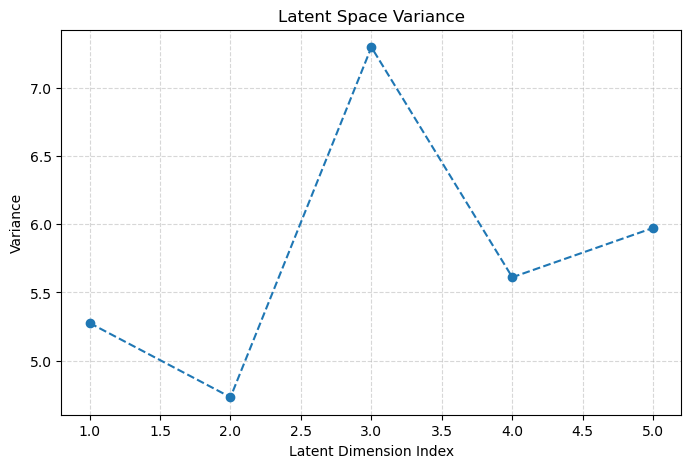

In [13]:
import numpy as np

# 获取编码器输出的潜在表示
# latent_representations = model.predict(X)  # 假设 encoder 是你的编码器模型

# 计算潜在表示每个维度的方差
variances = np.var(latent_df, axis=0)

# 绘制潜在表示方差图
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variances) + 1), variances, marker='o', linestyle='--')
plt.xlabel('Latent Dimension Index')
plt.ylabel('Variance')
plt.title('Latent Space Variance')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()


Epoch [1/200], Train Loss: 0.0340, Val Loss: 0.0316
Epoch [2/200], Train Loss: 0.0315, Val Loss: 0.0315
Epoch [3/200], Train Loss: 0.0314, Val Loss: 0.0315
Epoch [4/200], Train Loss: 0.0314, Val Loss: 0.0315
Epoch [5/200], Train Loss: 0.0314, Val Loss: 0.0315
Epoch [6/200], Train Loss: 0.0314, Val Loss: 0.0314
Epoch [7/200], Train Loss: 0.0314, Val Loss: 0.0314
Epoch [8/200], Train Loss: 0.0313, Val Loss: 0.0314
Epoch [9/200], Train Loss: 0.0313, Val Loss: 0.0314
Epoch [10/200], Train Loss: 0.0313, Val Loss: 0.0313
Epoch [11/200], Train Loss: 0.0313, Val Loss: 0.0313
Epoch [12/200], Train Loss: 0.0312, Val Loss: 0.0313
Epoch [13/200], Train Loss: 0.0312, Val Loss: 0.0312
Epoch [14/200], Train Loss: 0.0312, Val Loss: 0.0312
Epoch [15/200], Train Loss: 0.0311, Val Loss: 0.0312
Epoch [16/200], Train Loss: 0.0311, Val Loss: 0.0311
Epoch [17/200], Train Loss: 0.0310, Val Loss: 0.0312
Epoch [18/200], Train Loss: 0.0310, Val Loss: 0.0311
Epoch [19/200], Train Loss: 0.0310, Val Loss: 0.0310
Ep

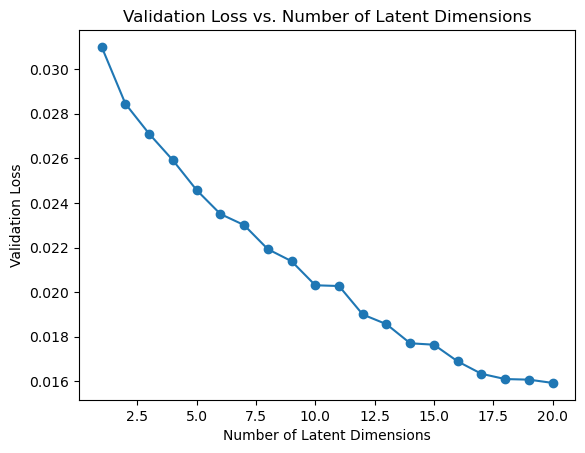

In [31]:
import matplotlib.pyplot as plt
#import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

# Assuming your questionnaire items are in columns named 'Q1' to 'Q100'
# questionnaire_columns = [col for col in data.columns if col.startswith('Q')]
X = qns.iloc[:,2:].values

# Standardize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Create PyTorch datasets and dataloaders
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same

train_dataset = QuestionnaireDataset(X_train)
val_dataset = QuestionnaireDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 2: Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = X_train.shape[1]
latent_dim = 5  # Reduce to 5 dimensions
latent_dims = range(1, 21)
val_losses = []

for latent_dim in latent_dims:
    model = Autoencoder(input_dim, latent_dim)

    # Step 3: Train the autoencoder
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 200
    patience = 10
    best_val_loss = float('inf')
    epochs_without_improvement = 0


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_features.size(0)
        train_loss /= len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, _ in val_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_features)
                val_loss += loss.item() * batch_features.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


        # 检查 Early Stopping 条件
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # 重置计数器
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    val_losses.append(val_loss)

plt.plot(latent_dims, val_losses, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of Latent Dimensions')
plt.show()


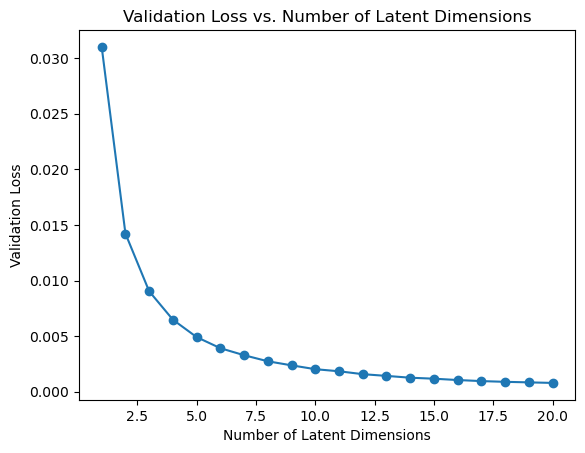

In [38]:
import matplotlib.pyplot as plt
avg_val=[]
for val, dim in zip(val_losses, latent_dims):
    avg_val.append(val/dim)

plt.plot(latent_dims, avg_val, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of Latent Dimensions')
plt.show()

Epoch [1/200], Train Loss: 0.0342, Val Loss: 0.0302
Epoch [2/200], Train Loss: 0.0298, Val Loss: 0.0296
Epoch [3/200], Train Loss: 0.0295, Val Loss: 0.0294
Epoch [4/200], Train Loss: 0.0293, Val Loss: 0.0293
Epoch [5/200], Train Loss: 0.0291, Val Loss: 0.0291
Epoch [6/200], Train Loss: 0.0290, Val Loss: 0.0291
Epoch [7/200], Train Loss: 0.0289, Val Loss: 0.0290
Epoch [8/200], Train Loss: 0.0288, Val Loss: 0.0289
Epoch [9/200], Train Loss: 0.0287, Val Loss: 0.0289
Epoch [10/200], Train Loss: 0.0286, Val Loss: 0.0287
Epoch [11/200], Train Loss: 0.0285, Val Loss: 0.0287
Epoch [12/200], Train Loss: 0.0284, Val Loss: 0.0287
Epoch [13/200], Train Loss: 0.0284, Val Loss: 0.0287
Epoch [14/200], Train Loss: 0.0283, Val Loss: 0.0286
Epoch [15/200], Train Loss: 0.0283, Val Loss: 0.0286
Epoch [16/200], Train Loss: 0.0282, Val Loss: 0.0286
Epoch [17/200], Train Loss: 0.0282, Val Loss: 0.0286
Epoch [18/200], Train Loss: 0.0282, Val Loss: 0.0286
Epoch [19/200], Train Loss: 0.0282, Val Loss: 0.0285
Ep

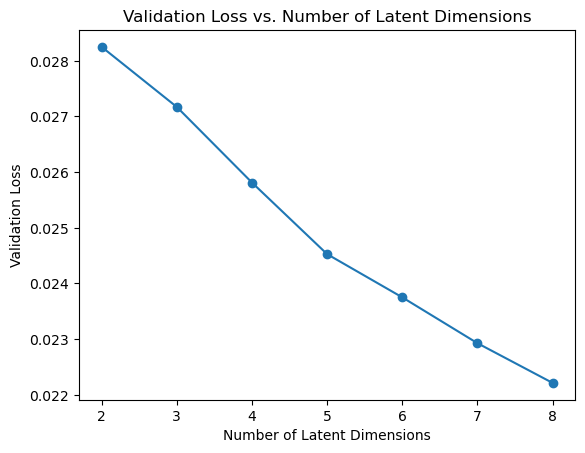

In [55]:
import matplotlib.pyplot as plt
#import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

# Assuming your questionnaire items are in columns named 'Q1' to 'Q100'
# questionnaire_columns = [col for col in data.columns if col.startswith('Q')]
X = qns.iloc[:,2:].values

# Standardize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Create PyTorch datasets and dataloaders
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same

train_dataset = QuestionnaireDataset(X_train)
val_dataset = QuestionnaireDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 2: Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = X_train.shape[1]
# latent_dim = 5  # Reduce to 5 dimensions
latent_dims = range(2, 9)
val_losses = []
explained_variance_ratios = []
for latent_dim in latent_dims:
    model = Autoencoder(input_dim, latent_dim)

    # Step 3: Train the autoencoder
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 200
    patience = 10
    best_val_loss = float('inf')
    epochs_without_improvement = 0


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_features.size(0)
        train_loss /= len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, _ in val_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_features)
                val_loss += loss.item() * batch_features.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        


        # 检查 Early Stopping 条件
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # 重置计数器
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    reconstructed = model(torch.tensor(X_scaled, dtype=torch.float32))
    mse = nn.MSELoss(reduction='none')
    reconstruction_error = mse(reconstructed, torch.tensor(X_scaled, dtype=torch.float32)).mean(dim=1).detach().numpy()
    print(f'Reconstruction Error: {reconstruction_error.mean()}')

    val_losses.append(val_loss)
    total_variance = np.var(X_scaled, axis=0).sum()
    # 计算每个因子贡献的方差
    # 通过重建数据的方差贡献，计算解释率
    reconstruction_variance = np.var(reconstructed.detach().numpy(), axis=0).sum()
    # 计算方差解释率
    explained_variance_ratio = reconstruction_variance / total_variance
    explained_variance_ratios.append(explained_variance_ratio)
plt.plot(latent_dims, val_losses, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of Latent Dimensions')
plt.show()


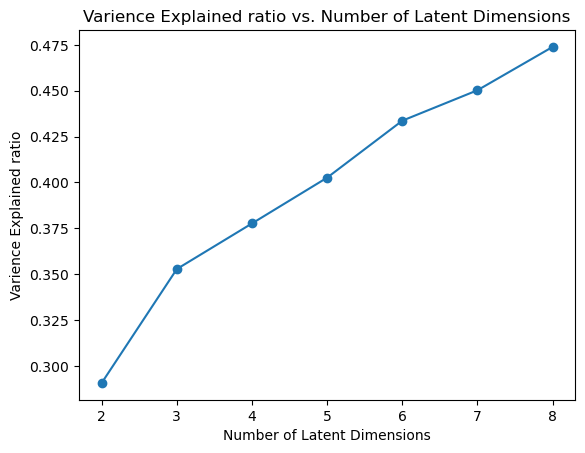

In [56]:
import matplotlib.pyplot as plt

plt.plot(latent_dims, explained_variance_ratios, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Varience Explained ratio')
plt.title('Varience Explained ratio vs. Number of Latent Dimensions')
plt.show()

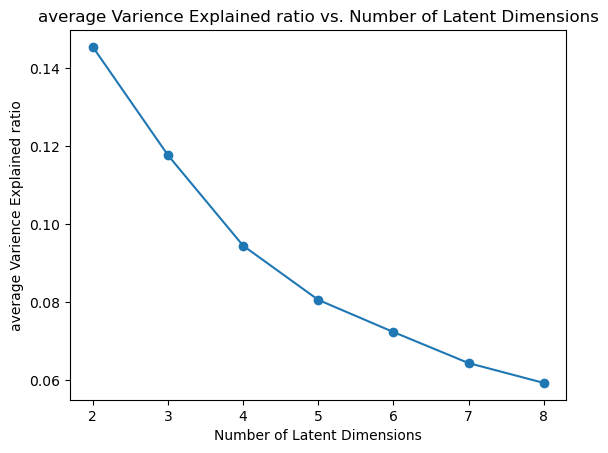

In [58]:
import matplotlib.pyplot as plt
avg_var=[]
for val, dim in zip(explained_variance_ratios, latent_dims):
    avg_var.append(val/dim)

plt.plot(latent_dims, avg_var, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('average Varience Explained ratio')
plt.title('average Varience Explained ratio vs. Number of Latent Dimensions')
plt.show()

In [43]:
explained_variance_ratios

[0.6124903649433933,
 0.6124903649433933,
 0.6124903649433933,
 0.6124903649433933,
 0.6124903649433933,
 0.6124903649433933,
 0.6124903649433933,
 0.6124903649433933,
 0.6124903649433933]

In [61]:
# 修改自编码器，移除非线性激活函数
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(LinearAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Linear(input_dim, latent_dim)
        # Decoder
        self.decoder = nn.Linear(latent_dim, input_dim)
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
model = LinearAutoencoder(input_dim, latent_dim)
# 获取编码器的权重矩阵
weight_matrix = model.encoder.weight.data.numpy()
# 对权重矩阵进行奇异值分解
U, S, Vt = np.linalg.svd(weight_matrix, full_matrices=False)
# S 包含奇异值


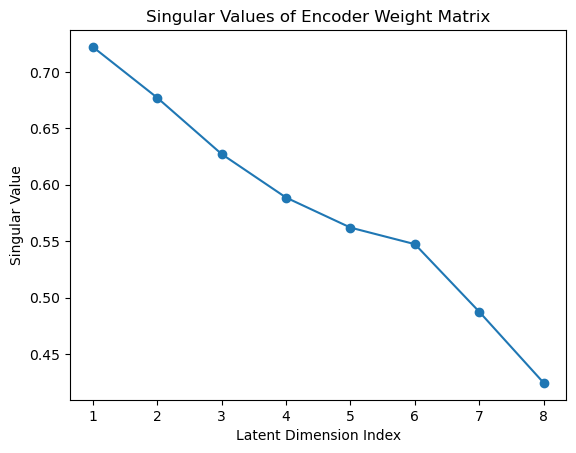

In [63]:
plt.plot(range(1, len(S)+1), S, marker='o')
plt.xlabel('Latent Dimension Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Encoder Weight Matrix')
plt.show()


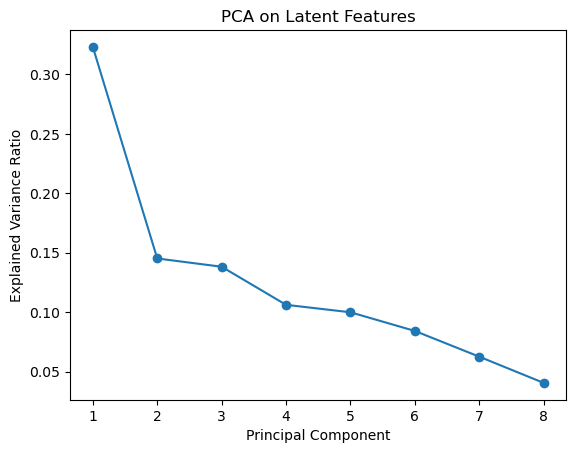

In [64]:
from sklearn.decomposition import PCA

# 获取潜在表示
latent_features = model.encoder(torch.tensor(X_scaled, dtype=torch.float32)).detach().numpy()
# 对潜在表示进行 PCA
pca = PCA()
pca.fit(latent_features)
# 获取解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 绘制解释方差比例图
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA on Latent Features')
plt.show()


In [24]:
latent_dims

range(1, 21)

In [27]:
len(val_losses)

159

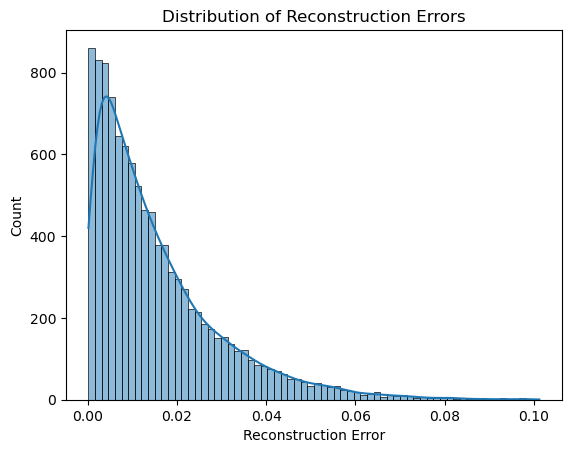

In [32]:
import seaborn as sns

# 计算所有样本的重构误差
model.eval()
with torch.no_grad():
    reconstructed = model(torch.tensor(X_scaled, dtype=torch.float32))
    reconstruction_errors = torch.mean((torch.tensor(X_scaled, dtype=torch.float32) - reconstructed) ** 2, dim=1).numpy()

sns.histplot(reconstruction_errors, kde=True)
plt.xlabel('Reconstruction Error')
plt.title('Distribution of Reconstruction Errors')
plt.show()


# FNC

In [79]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# load data and drop the first column and the subject id
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_gp.csv")
# only keep eventname = baseline_year_1_arm_1
data = data[data['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname']).dropna()

# labels = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\EFA.csv').iloc[:, 1:]
labels = pd.read_csv(r'G:/ABCD/data/mh_p_cbcl.csv')
# only keep the  column.('cbcl_scr_syn_anxdep_t')
labels = labels[labels['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname'])
labels = labels[['src_subject_id', 'cbcl_scr_syn_anxdep_t']].dropna()

# only keep the subjects that have labels
data = data[data['src_subject_id'].isin(labels["src_subject_id"])]
labels = labels[labels['src_subject_id'].isin(data["src_subject_id"])]

# data = data.drop(columns=['src_subject_id'])
# labels = labels.drop(columns=['src_subject_id'])

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\801679093.py:10: DtypeWarning: Columns (124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv(r'G:/ABCD/data/mh_p_cbcl.csv')


In [80]:
data

,src_subject_id,rsfmri_c_ngd_ad_ngd_ad,rsfmri_c_ngd_ad_ngd_cgc,rsfmri_c_ngd_ad_ngd_ca,rsfmri_c_ngd_ad_ngd_dt,rsfmri_c_ngd_ad_ngd_dla,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_n,rsfmri_c_ngd_ad_ngd_rspltp,rsfmri_c_ngd_ad_ngd_sa,...,rsfmri_c_ngd_vs_ngd_dt,rsfmri_c_ngd_vs_ngd_dla,rsfmri_c_ngd_vs_ngd_fo,rsfmri_c_ngd_vs_ngd_n,rsfmri_c_ngd_vs_ngd_rspltp,rsfmri_c_ngd_vs_ngd_sa,rsfmri_c_ngd_vs_ngd_smh,rsfmri_c_ngd_vs_ngd_smm,rsfmri_c_ngd_vs_ngd_vta,rsfmri_c_ngd_vs_ngd_vs
0,NDAR_INV003RTV85,0.471330,0.256267,-0.076960,-0.116451,0.022202,-0.036302,-0.057183,-0.048132,0.006416,...,-0.088894,0.055355,-0.076806,-0.006004,0.228366,-0.150867,-0.064416,0.098679,-0.155134,0.371960
1,NDAR_INV005V6D2C,0.279435,0.116256,0.063664,-0.024781,-0.000840,-0.023421,-0.016284,0.022696,0.056241,...,-0.136596,0.017415,-0.111623,-0.077958,0.049159,-0.065420,-0.061459,0.075145,-0.071943,0.346746
2,NDAR_INV007W6H7B,0.294463,0.209772,-0.071834,-0.138693,-0.035168,0.044412,-0.041321,-0.185939,0.071985,...,-0.136426,-0.018266,-0.096822,-0.050623,0.002644,-0.017955,-0.060259,0.070566,-0.076156,0.400397
3,NDAR_INV00BD7VDC,0.241918,0.163942,-0.090651,-0.044039,0.012523,-0.022455,-0.005482,-0.124627,0.095889,...,-0.117847,0.007997,-0.117152,-0.028143,0.079898,-0.066724,-0.029856,-0.038823,-0.092095,0.334313
6,NDAR_INV00CY2MDM,0.395300,0.180940,-0.142808,-0.073424,-0.049414,-0.144481,-0.024881,-0.012894,-0.036592,...,-0.202610,0.014283,-0.200163,-0.091514,0.154572,-0.210839,0.033060,0.159728,-0.125210,0.485745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,NDAR_INVZZLZCKAY,0.315367,0.176642,-0.010926,-0.019208,-0.030765,-0.062264,0.021828,-0.043990,0.140031,...,-0.075473,-0.008800,-0.103751,-0.035379,0.183831,-0.019576,-0.045539,-0.012037,-0.054182,0.333367
22120,NDAR_INVZZNX6W2P,0.343187,0.142774,-0.055901,-0.046064,-0.006279,0.013171,0.017289,-0.064605,-0.014693,...,-0.164360,0.059505,-0.157277,-0.037063,0.264306,-0.143545,-0.082002,0.015764,-0.126353,0.484629
22123,NDAR_INVZZPKBDAC,0.404070,0.300714,-0.167735,-0.093816,-0.044867,0.019305,0.049103,-0.157262,0.192685,...,-0.183933,0.022202,-0.130174,-0.066710,0.179635,-0.012360,-0.098269,0.069790,-0.126898,0.462496
22125,NDAR_INVZZZ2ALR6,0.411105,0.209193,-0.041473,-0.063504,-0.102791,-0.046049,-0.009828,-0.162120,0.026045,...,-0.152191,0.022720,-0.132211,-0.046361,0.170122,-0.094498,0.000854,0.030236,-0.153170,0.351791


In [68]:
import itertools
import numpy as np
import pandas as pd

def parse_fnc(x):
    return [c[:-4] for c in x.split('_vs_')]

def compute_fnc_agg(df, pair_cols):
    df_res = pd.DataFrame()
    
    for c in pair_cols.keys():
        df_res[c[0] + '_' + c[1] + '_mean'] = df[pair_cols[c]].mean(axis=1)
        df_res[c[0] + '_' + c[1] + '_min'] = df[pair_cols[c]].min(axis=1)
        df_res[c[0] + '_' + c[1] + '_max'] = df[pair_cols[c]].max(axis=1)
        df_res[c[0] + '_' + c[1] + '_std'] = df[pair_cols[c]].std(axis=1).fillna(0)

    return df_res

# load data
print('Loading data...')
# df = pd.read_csv('./data/raw/fnc.csv')
df = data
fnc_cols = sorted(df.columns[1:])

# generate pair of cols
pair_cols = {}
colz = ['SCN', 'ADN', 'SMN', 'VSN', 'CON', 'DMN', 'CBN']
for pair in itertools.combinations_with_replacement(colz, 2):
    pair_cols[pair] = [c for c in fnc_cols if set(parse_fnc(c)) == set(pair)]

# compute features
print('Computing features...')
agg_feats = compute_fnc_agg(df, pair_cols)
agg_feats = agg_feats[agg_feats.std()[agg_feats.std() != 0].index]
agg_feats.columns = ['AGG_' + c.lower() for c in agg_feats.columns]
#agg_feats['Id'] = df['Id']
agg_feats = pd.concat((df[['src_subject_id']], agg_feats), axis=1)
# agg_feats.to_csv('./data/features/agg_feats.csv', index=False)

Loading data...
Computing features...


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\1418452100.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_res[c[0] + '_' + c[1] + '_mean'] = df[pair_cols[c]].mean(axis=1)
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\1418452100.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_res[c[0] + '_' + c[1] + '_min'] = df[pair_cols[c]].min(axis=1)
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\1418452100.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [110]:
import pandas as pd
import itertools

# 加载数据
print('Loading data...')
df = data

# 提取所有列名
fnc_cols = df.columns[1:]  # 排除 'src_subject_id' 列

# 自动解析并提取网络名称
def parse_fnc(x):
    parts = x.split('_')
    return parts[2], parts[3]  # 假设网络名称总是在第3和第4个位置

# 检查解析结果
for col in fnc_cols[:5]:  # 打印前5个列名的解析结果进行检查
    print(f"Original: {col}, Parsed: {parse_fnc(col)}")

# 生成网络名称集合
network_names = set()
for col in fnc_cols:
    network1, network2 = parse_fnc(col)
    network_names.add(network1)
    network_names.add(network2)

# 将网络名称转换为列表并排序
colz = sorted(network_names)
print("Detected network names:", colz)

# 生成网络对列
pair_cols = {}
for pair in itertools.combinations_with_replacement(colz, 2):
    pair_cols[pair] = [c for c in fnc_cols if set(parse_fnc(c)) == set(pair)]

# 检查 pair_cols 是否正确匹配
print("Example of pair_cols content:", {k: v for k, v in list(pair_cols.items())[:5]})

# 定义聚合特征计算函数
def compute_fnc_agg(df, pair_cols):
    df_res = pd.DataFrame()
    for c in pair_cols.keys():
        if pair_cols[c]:  # 检查是否有匹配的列
            df_res[c[0] + '_' + c[1] + '_mean'] = df[pair_cols[c]].mean(axis=1)
            df_res[c[0] + '_' + c[1] + '_min'] = df[pair_cols[c]].min(axis=1)
            df_res[c[0] + '_' + c[1] + '_max'] = df[pair_cols[c]].max(axis=1)
            df_res[c[0] + '_' + c[1] + '_std'] = df[pair_cols[c]].std(axis=1).fillna(0)
    return df_res

# 计算特征
print('Computing features...')
agg_feats = compute_fnc_agg(df, pair_cols)

# 过滤掉标准差为0的列并重命名
agg_feats = agg_feats[agg_feats.std()[agg_feats.std() != 0].index]
agg_feats.columns = ['AGG_' + c.lower() for c in agg_feats.columns]

# 合并 'src_subject_id' 列
agg_feats = pd.concat((df[['src_subject_id']], agg_feats), axis=1)

# # 保存到 CSV 文件
# agg_feats.to_csv('./data/features/agg_feats.csv', index=False)


Loading data...
Original: rsfmri_c_ngd_ad_ngd_ad, Parsed: ('ngd', 'ad')
Original: rsfmri_c_ngd_ad_ngd_cgc, Parsed: ('ngd', 'ad')
Original: rsfmri_c_ngd_ad_ngd_ca, Parsed: ('ngd', 'ad')
Original: rsfmri_c_ngd_ad_ngd_dt, Parsed: ('ngd', 'ad')
Original: rsfmri_c_ngd_ad_ngd_dla, Parsed: ('ngd', 'ad')
Detected network names: ['ad', 'ca', 'cgc', 'dla', 'dt', 'fo', 'n', 'ngd', 'rspltp', 'sa', 'smh', 'smm', 'vs', 'vta']
Example of pair_cols content: {('ad', 'ad'): [], ('ad', 'ca'): [], ('ad', 'cgc'): [], ('ad', 'dla'): [], ('ad', 'dt'): []}
Computing features...


In [108]:
import itertools
import numpy as np
import pandas as pd

def parse_fnc(x):
    return [c[:-4] for c in x.split('_vs_')]

def compute_fnc_agg(df, pair_cols):
    df_res = pd.DataFrame()
    
    for c in pair_cols.keys():
        df_res[c[0] + '_' + c[1] + '_mean'] = df[pair_cols[c]].mean(axis=1)
        df_res[c[0] + '_' + c[1] + '_min'] = df[pair_cols[c]].min(axis=1)
        df_res[c[0] + '_' + c[1] + '_max'] = df[pair_cols[c]].max(axis=1)
        df_res[c[0] + '_' + c[1] + '_std'] = df[pair_cols[c]].std(axis=1).fillna(0)

    return df_res

# load data
print('Loading data...')
df = data

fnc_cols = df.columns[1:]  # 排除 'src_subject_id' 列

# generate pair of cols
pair_cols = {}
colz = ['ad', 'ca', 'cgc', 'dla', 'dt', 'fo', 'n', 'rspltp', 'sa', 'smh', 'smm', 'vs', 'vta']
for pair in itertools.combinations_with_replacement(colz, 2):
    pair_cols[pair] = [c for c in fnc_cols if set(parse_fnc(c)) == set(pair)]

# compute features
print('Computing features...')
agg_feats = compute_fnc_agg(df, pair_cols)
agg_feats = agg_feats[agg_feats.std()[agg_feats.std() != 0].index]
agg_feats.columns = ['AGG_' + c.lower() for c in agg_feats.columns]
#agg_feats['Id'] = df['Id']
agg_feats = pd.concat((df[['src_subject_id']], agg_feats), axis=1)
# agg_feats.to_csv('./data/features/agg_feats.csv', index=False)

Loading data...
Computing features...


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\2611962364.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_res[c[0] + '_' + c[1] + '_mean'] = df[pair_cols[c]].mean(axis=1)
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\2611962364.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_res[c[0] + '_' + c[1] + '_min'] = df[pair_cols[c]].min(axis=1)
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\2611962364.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [115]:
agg_feats

,src_subject_id
0,NDAR_INV003RTV85
1,NDAR_INV005V6D2C
2,NDAR_INV007W6H7B
3,NDAR_INV00BD7VDC
6,NDAR_INV00CY2MDM
...,...
22117,NDAR_INVZZLZCKAY
22120,NDAR_INVZZNX6W2P
22123,NDAR_INVZZPKBDAC
22125,NDAR_INVZZZ2ALR6


In [97]:
fnc_cols

Index(['rsfmri_c_ngd_ad_ngd_ad', 'rsfmri_c_ngd_ad_ngd_cgc',
       'rsfmri_c_ngd_ad_ngd_ca', 'rsfmri_c_ngd_ad_ngd_dt',
       'rsfmri_c_ngd_ad_ngd_dla', 'rsfmri_c_ngd_ad_ngd_fo',
       'rsfmri_c_ngd_ad_ngd_n', 'rsfmri_c_ngd_ad_ngd_rspltp',
       'rsfmri_c_ngd_ad_ngd_sa', 'rsfmri_c_ngd_ad_ngd_smh',
       ...
       'rsfmri_c_ngd_vs_ngd_dt', 'rsfmri_c_ngd_vs_ngd_dla',
       'rsfmri_c_ngd_vs_ngd_fo', 'rsfmri_c_ngd_vs_ngd_n',
       'rsfmri_c_ngd_vs_ngd_rspltp', 'rsfmri_c_ngd_vs_ngd_sa',
       'rsfmri_c_ngd_vs_ngd_smh', 'rsfmri_c_ngd_vs_ngd_smm',
       'rsfmri_c_ngd_vs_ngd_vta', 'rsfmri_c_ngd_vs_ngd_vs'],
      dtype='object', length=169)

In [98]:
parts

['rsfmri', 'c', 'ngd', 'vs', 'ngd', 'vs']

In [99]:
network_names

{'ngd'}

In [100]:
# 提取所有列名
fnc_cols = df.columns[1:]

# 创建一个集合来存储唯一的网络名称
network_names = set()

# 遍历每个列名并提取网络名称
for col in fnc_cols:
    parts = col.split('_')  # 使用下划线分割列名
    # 提取网络名称并添加到集合中
    network_names.add(parts[2])  # 第一个网络名
    network_names.add(parts[4])  # 第二个网络名

# 将集合转换为排序后的列表
network_names_list = sorted(network_names)

print("提取的网络名称:", network_names_list)


提取的网络名称: ['ngd']


In [104]:
network_names.add(parts[3])

In [106]:
# 提取从第二个开始的列名，跳过第一个列名
fnc_cols = df.columns[1:]

# 创建一个集合来存储唯一的网络名称
network_names = set()

# 遍历每个列名并提取网络名称
for col in fnc_cols:
    parts = col.split('_')
    # 正确提取网络名称
    network_names.add(parts[3])  # 第一个网络名
    network_names.add(parts[5])  # 第二个网络名

# 将集合转换为排序后的列表
network_names_list = sorted(network_names)

print("提取的网络名称:", network_names_list)


提取的网络名称: ['ad', 'ca', 'cgc', 'dla', 'dt', 'fo', 'n', 'rspltp', 'sa', 'smh', 'smm', 'vs', 'vta']


In [116]:
import itertools
import numpy as np
import pandas as pd

# 加载数据
print('Loading data...')
df = data

# 提取从第二个开始的列名，跳过第一个列名
fnc_cols = df.columns[1:]  # 排除 'src_subject_id' 列

# 创建一个集合来存储唯一的网络名称
network_names = set()

# 遍历每个列名并提取网络名称
for col in fnc_cols:
    parts = col.split('_')
    # 正确提取网络名称
    network_names.add(parts[3])  # 第一个网络名
    network_names.add(parts[5])  # 第二个网络名

# 将集合转换为排序后的列表
colz = sorted(network_names)
print("提取的网络名称:", colz)

# 修改后的解析函数，使用分割好的网络名称
def parse_fnc(x):
    parts = x.split('_')
    return [parts[3], parts[5]]  # 返回正确的网络名称

# 生成网络对列
pair_cols = {}
for pair in itertools.combinations_with_replacement(colz, 2):
    # 匹配列名，并检查是否有匹配的列
    pair_cols[pair] = [c for c in fnc_cols if set(parse_fnc(c)) == set(pair)]
    if len(pair_cols[pair]) == 0:  # 打印未匹配的网络对
        print(f"No matching columns for pair: {pair}")

# 计算聚合特征
def compute_fnc_agg(df, pair_cols):
    df_res = pd.DataFrame()
    for c in pair_cols.keys():
        if len(pair_cols[c]) > 0:  # 仅对有匹配列的网络对计算特征
            df_res[c[0] + '_' + c[1] + '_mean'] = df[pair_cols[c]].mean(axis=1)
            df_res[c[0] + '_' + c[1] + '_min'] = df[pair_cols[c]].min(axis=1)
            df_res[c[0] + '_' + c[1] + '_max'] = df[pair_cols[c]].max(axis=1)
            df_res[c[0] + '_' + c[1] + '_std'] = df[pair_cols[c]].std(axis=1).fillna(0)
    return df_res

# 计算特征
print('Computing features...')
agg_feats = compute_fnc_agg(df, pair_cols)

# 检查 agg_feats 是否为空
if agg_feats.empty:
    print("No features were generated. Check the matching logic.")

# 过滤掉标准差为0的列并重命名
agg_feats = agg_feats[agg_feats.std()[agg_feats.std() != 0].index]
agg_feats.columns = ['AGG_' + c.lower() for c in agg_feats.columns]

# 合并 'src_subject_id' 列
agg_feats = pd.concat((df[['src_subject_id']], agg_feats), axis=1)

# 取消注释以保存特征到 CSV 文件
# agg_feats.to_csv('./data/features/agg_feats.csv', index=False)


Loading data...
提取的网络名称: ['ad', 'ca', 'cgc', 'dla', 'dt', 'fo', 'n', 'rspltp', 'sa', 'smh', 'smm', 'vs', 'vta']
Computing features...


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\1714619537.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_res[c[0] + '_' + c[1] + '_mean'] = df[pair_cols[c]].mean(axis=1)
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\1714619537.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_res[c[0] + '_' + c[1] + '_min'] = df[pair_cols[c]].min(axis=1)
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_5648\1714619537.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [154]:
agg_feats

,src_subject_id,AGG_ad_ad_mean,AGG_ad_ad_min,AGG_ad_ad_max,AGG_ad_ca_mean,AGG_ad_ca_min,AGG_ad_ca_max,AGG_ad_cgc_mean,AGG_ad_cgc_min,AGG_ad_cgc_max,...,AGG_smm_vta_max,AGG_vs_vs_mean,AGG_vs_vs_min,AGG_vs_vs_max,AGG_vs_vta_mean,AGG_vs_vta_min,AGG_vs_vta_max,AGG_vta_vta_mean,AGG_vta_vta_min,AGG_vta_vta_max
0,NDAR_INV003RTV85,0.471330,0.471330,0.471330,-0.076960,-0.076960,-0.076960,0.256267,0.256267,0.256267,...,-0.042176,0.371960,0.371960,0.371960,-0.155134,-0.155134,-0.155134,0.233819,0.233819,0.233819
1,NDAR_INV005V6D2C,0.279435,0.279435,0.279435,0.063664,0.063664,0.063664,0.116256,0.116256,0.116256,...,-0.007564,0.346746,0.346746,0.346746,-0.071943,-0.071943,-0.071943,0.173929,0.173929,0.173929
2,NDAR_INV007W6H7B,0.294463,0.294463,0.294463,-0.071834,-0.071834,-0.071834,0.209772,0.209772,0.209772,...,0.026875,0.400397,0.400397,0.400397,-0.076156,-0.076156,-0.076156,0.257184,0.257184,0.257184
3,NDAR_INV00BD7VDC,0.241918,0.241918,0.241918,-0.090651,-0.090651,-0.090651,0.163942,0.163942,0.163942,...,0.011466,0.334313,0.334313,0.334313,-0.092095,-0.092095,-0.092095,0.167689,0.167689,0.167689
6,NDAR_INV00CY2MDM,0.395300,0.395300,0.395300,-0.142808,-0.142808,-0.142808,0.180940,0.180940,0.180940,...,0.074829,0.485745,0.485745,0.485745,-0.125210,-0.125210,-0.125210,0.230946,0.230946,0.230946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,NDAR_INVZZLZCKAY,0.315367,0.315367,0.315367,-0.010926,-0.010926,-0.010926,0.176642,0.176642,0.176642,...,0.025325,0.333367,0.333367,0.333367,-0.054182,-0.054182,-0.054182,0.183470,0.183470,0.183470
22120,NDAR_INVZZNX6W2P,0.343187,0.343187,0.343187,-0.055901,-0.055901,-0.055901,0.142774,0.142774,0.142774,...,0.018554,0.484629,0.484629,0.484629,-0.126353,-0.126353,-0.126353,0.238454,0.238454,0.238454
22123,NDAR_INVZZPKBDAC,0.404070,0.404070,0.404070,-0.167735,-0.167735,-0.167735,0.300714,0.300714,0.300714,...,0.128084,0.462496,0.462496,0.462496,-0.126898,-0.126898,-0.126898,0.267290,0.267290,0.267290
22125,NDAR_INVZZZ2ALR6,0.411105,0.411105,0.411105,-0.041473,-0.041473,-0.041473,0.209193,0.209193,0.209193,...,0.029845,0.351791,0.351791,0.351791,-0.153170,-0.153170,-0.153170,0.301422,0.301422,0.301422


In [155]:
#筛选所有列名结尾为_mean的列
mean_cols = [c for c in agg_feats.columns if c.endswith('_mean')]

In [156]:
mean_df = agg_feats[['src_subject_id']+ mean_cols]

In [157]:
mean_df

,src_subject_id,AGG_ad_ad_mean,AGG_ad_ca_mean,AGG_ad_cgc_mean,AGG_ad_dla_mean,AGG_ad_dt_mean,AGG_ad_fo_mean,AGG_ad_n_mean,AGG_ad_rspltp_mean,AGG_ad_sa_mean,...,AGG_smh_smh_mean,AGG_smh_smm_mean,AGG_smh_vs_mean,AGG_smh_vta_mean,AGG_smm_smm_mean,AGG_smm_vs_mean,AGG_smm_vta_mean,AGG_vs_vs_mean,AGG_vs_vta_mean,AGG_vta_vta_mean
0,NDAR_INV003RTV85,0.471330,-0.076960,0.256267,0.022202,-0.116451,-0.036302,-0.057183,-0.048132,0.006416,...,0.314437,0.056185,-0.064416,-0.042587,0.610255,0.098679,-0.042176,0.371960,-0.155134,0.233819
1,NDAR_INV005V6D2C,0.279435,0.063664,0.116256,-0.000840,-0.024781,-0.023421,-0.016284,0.022696,0.056241,...,0.302632,0.062337,-0.061459,0.023958,0.506645,0.075145,-0.007564,0.346746,-0.071943,0.173929
2,NDAR_INV007W6H7B,0.294463,-0.071834,0.209772,-0.035168,-0.138693,0.044412,-0.041321,-0.185939,0.071985,...,0.288158,0.088796,-0.060259,0.002308,0.683473,0.070566,0.026875,0.400397,-0.076156,0.257184
3,NDAR_INV00BD7VDC,0.241918,-0.090651,0.163942,0.012523,-0.044039,-0.022455,-0.005482,-0.124627,0.095889,...,0.333995,0.056474,-0.029856,0.020649,0.477314,-0.038823,0.011466,0.334313,-0.092095,0.167689
6,NDAR_INV00CY2MDM,0.395300,-0.142808,0.180940,-0.049414,-0.073424,-0.144481,-0.024881,-0.012894,-0.036592,...,0.426006,0.380348,0.033060,0.032599,0.818149,0.159728,0.074829,0.485745,-0.125210,0.230946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,NDAR_INVZZLZCKAY,0.315367,-0.010926,0.176642,-0.030765,-0.019208,-0.062264,0.021828,-0.043990,0.140031,...,0.211188,0.024467,-0.045539,0.006467,0.596059,-0.012037,0.025325,0.333367,-0.054182,0.183470
22120,NDAR_INVZZNX6W2P,0.343187,-0.055901,0.142774,-0.006279,-0.046064,0.013171,0.017289,-0.064605,-0.014693,...,0.379075,0.120344,-0.082002,-0.003782,0.715068,0.015764,0.018554,0.484629,-0.126353,0.238454
22123,NDAR_INVZZPKBDAC,0.404070,-0.167735,0.300714,-0.044867,-0.093816,0.019305,0.049103,-0.157262,0.192685,...,0.223616,-0.033873,-0.098269,-0.007025,0.840622,0.069790,0.128084,0.462496,-0.126898,0.267290
22125,NDAR_INVZZZ2ALR6,0.411105,-0.041473,0.209193,-0.102791,-0.063504,-0.046049,-0.009828,-0.162120,0.026045,...,0.302695,0.071764,0.000854,-0.082954,0.723260,0.030236,0.029845,0.351791,-0.153170,0.301422


In [146]:
latent_df

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,0.225962,-0.987701,1.428785,0.196275,2.294005
1,-0.270909,-1.172184,1.699451,1.889652,2.205972
2,-0.170160,0.610330,-0.446073,2.320928,1.705356
3,0.410402,-0.158501,0.223055,3.264879,1.840801
4,3.462913,-5.130525,1.558750,5.146125,-4.048456
...,...,...,...,...,...
10647,-6.752625,5.188299,0.805525,-0.362465,-2.794127
10648,0.047847,-2.206021,1.290669,3.946332,-0.416121
10649,-0.721727,-0.715168,1.275204,0.842071,2.017429
10650,-0.617627,-1.584424,0.179293,1.639837,0.536771


In [147]:
qns

,Unnamed: 0,src_subject_id,cbcl_q01_p,cbcl_q03_p,cbcl_q04_p,cbcl_q05_p,cbcl_q06_p,cbcl_q07_p,cbcl_q08_p,cbcl_q09_p,...,cbcl_q102_p,cbcl_q103_p,cbcl_q104_p,cbcl_q106_p,cbcl_q107_p,cbcl_q108_p,cbcl_q109_p,cbcl_q110_p,cbcl_q111_p,cbcl_q112_p
0,1,NDAR_INV003RTV85,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,NDAR_INV005V6D2C,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,NDAR_INV007W6H7B,0,1,0,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,1
3,4,NDAR_INV00BD7VDC,0,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
4,5,NDAR_INV00CY2MDM,1,2,1,0,0,1,2,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10647,11158,NDAR_INVZZLZCKAY,0,2,1,0,0,0,1,1,...,1,0,1,0,0,0,1,0,1,1
10648,11159,NDAR_INVZZNX6W2P,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
10649,11160,NDAR_INVZZPKBDAC,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10650,11161,NDAR_INVZZZ2ALR6,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
mean_df = mean_df[mean_df['src_subject_id'].isin(scores["src_subject_id"])]


In [149]:
mean_df

,src_subject_id,AGG_ad_ad_mean,AGG_ad_ca_mean,AGG_ad_cgc_mean,AGG_ad_dla_mean,AGG_ad_dt_mean,AGG_ad_fo_mean,AGG_ad_n_mean,AGG_ad_rspltp_mean,AGG_ad_sa_mean,...,AGG_smh_smh_mean,AGG_smh_smm_mean,AGG_smh_vs_mean,AGG_smh_vta_mean,AGG_smm_smm_mean,AGG_smm_vs_mean,AGG_smm_vta_mean,AGG_vs_vs_mean,AGG_vs_vta_mean,AGG_vta_vta_mean
0,NDAR_INV003RTV85,0.471330,-0.076960,0.256267,0.022202,-0.116451,-0.036302,-0.057183,-0.048132,0.006416,...,0.314437,0.056185,-0.064416,-0.042587,0.610255,0.098679,-0.042176,0.371960,-0.155134,0.233819
1,NDAR_INV005V6D2C,0.279435,0.063664,0.116256,-0.000840,-0.024781,-0.023421,-0.016284,0.022696,0.056241,...,0.302632,0.062337,-0.061459,0.023958,0.506645,0.075145,-0.007564,0.346746,-0.071943,0.173929
2,NDAR_INV007W6H7B,0.294463,-0.071834,0.209772,-0.035168,-0.138693,0.044412,-0.041321,-0.185939,0.071985,...,0.288158,0.088796,-0.060259,0.002308,0.683473,0.070566,0.026875,0.400397,-0.076156,0.257184
3,NDAR_INV00BD7VDC,0.241918,-0.090651,0.163942,0.012523,-0.044039,-0.022455,-0.005482,-0.124627,0.095889,...,0.333995,0.056474,-0.029856,0.020649,0.477314,-0.038823,0.011466,0.334313,-0.092095,0.167689
6,NDAR_INV00CY2MDM,0.395300,-0.142808,0.180940,-0.049414,-0.073424,-0.144481,-0.024881,-0.012894,-0.036592,...,0.426006,0.380348,0.033060,0.032599,0.818149,0.159728,0.074829,0.485745,-0.125210,0.230946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,NDAR_INVZZLZCKAY,0.315367,-0.010926,0.176642,-0.030765,-0.019208,-0.062264,0.021828,-0.043990,0.140031,...,0.211188,0.024467,-0.045539,0.006467,0.596059,-0.012037,0.025325,0.333367,-0.054182,0.183470
22120,NDAR_INVZZNX6W2P,0.343187,-0.055901,0.142774,-0.006279,-0.046064,0.013171,0.017289,-0.064605,-0.014693,...,0.379075,0.120344,-0.082002,-0.003782,0.715068,0.015764,0.018554,0.484629,-0.126353,0.238454
22123,NDAR_INVZZPKBDAC,0.404070,-0.167735,0.300714,-0.044867,-0.093816,0.019305,0.049103,-0.157262,0.192685,...,0.223616,-0.033873,-0.098269,-0.007025,0.840622,0.069790,0.128084,0.462496,-0.126898,0.267290
22125,NDAR_INVZZZ2ALR6,0.411105,-0.041473,0.209193,-0.102791,-0.063504,-0.046049,-0.009828,-0.162120,0.026045,...,0.302695,0.071764,0.000854,-0.082954,0.723260,0.030236,0.029845,0.351791,-0.153170,0.301422


In [131]:
mean_df = mean_df.drop(columns=['src_subject_id'])

In [133]:
mean_df

,AGG_ad_ad_mean,AGG_ad_ca_mean,AGG_ad_cgc_mean,AGG_ad_dla_mean,AGG_ad_dt_mean,AGG_ad_fo_mean,AGG_ad_n_mean,AGG_ad_rspltp_mean,AGG_ad_sa_mean,AGG_ad_smh_mean,...,AGG_smh_smh_mean,AGG_smh_smm_mean,AGG_smh_vs_mean,AGG_smh_vta_mean,AGG_smm_smm_mean,AGG_smm_vs_mean,AGG_smm_vta_mean,AGG_vs_vs_mean,AGG_vs_vta_mean,AGG_vta_vta_mean
0,0.471330,-0.076960,0.256267,0.022202,-0.116451,-0.036302,-0.057183,-0.048132,0.006416,0.199033,...,0.314437,0.056185,-0.064416,-0.042587,0.610255,0.098679,-0.042176,0.371960,-0.155134,0.233819
1,0.279435,0.063664,0.116256,-0.000840,-0.024781,-0.023421,-0.016284,0.022696,0.056241,0.110631,...,0.302632,0.062337,-0.061459,0.023958,0.506645,0.075145,-0.007564,0.346746,-0.071943,0.173929
2,0.294463,-0.071834,0.209772,-0.035168,-0.138693,0.044412,-0.041321,-0.185939,0.071985,0.096365,...,0.288158,0.088796,-0.060259,0.002308,0.683473,0.070566,0.026875,0.400397,-0.076156,0.257184
3,0.241918,-0.090651,0.163942,0.012523,-0.044039,-0.022455,-0.005482,-0.124627,0.095889,0.151396,...,0.333995,0.056474,-0.029856,0.020649,0.477314,-0.038823,0.011466,0.334313,-0.092095,0.167689
6,0.395300,-0.142808,0.180940,-0.049414,-0.073424,-0.144481,-0.024881,-0.012894,-0.036592,0.321739,...,0.426006,0.380348,0.033060,0.032599,0.818149,0.159728,0.074829,0.485745,-0.125210,0.230946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.315367,-0.010926,0.176642,-0.030765,-0.019208,-0.062264,0.021828,-0.043990,0.140031,0.099674,...,0.211188,0.024467,-0.045539,0.006467,0.596059,-0.012037,0.025325,0.333367,-0.054182,0.183470
22120,0.343187,-0.055901,0.142774,-0.006279,-0.046064,0.013171,0.017289,-0.064605,-0.014693,0.149963,...,0.379075,0.120344,-0.082002,-0.003782,0.715068,0.015764,0.018554,0.484629,-0.126353,0.238454
22123,0.404070,-0.167735,0.300714,-0.044867,-0.093816,0.019305,0.049103,-0.157262,0.192685,0.052396,...,0.223616,-0.033873,-0.098269,-0.007025,0.840622,0.069790,0.128084,0.462496,-0.126898,0.267290
22125,0.411105,-0.041473,0.209193,-0.102791,-0.063504,-0.046049,-0.009828,-0.162120,0.026045,0.078251,...,0.302695,0.071764,0.000854,-0.082954,0.723260,0.030236,0.029845,0.351791,-0.153170,0.301422


In [134]:
latent_df

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,0.225962,-0.987701,1.428785,0.196275,2.294005
1,-0.270909,-1.172184,1.699451,1.889652,2.205972
2,-0.170160,0.610330,-0.446073,2.320928,1.705356
3,0.410402,-0.158501,0.223055,3.264879,1.840801
4,3.462913,-5.130525,1.558750,5.146125,-4.048456
...,...,...,...,...,...
10647,-6.752625,5.188299,0.805525,-0.362465,-2.794127
10648,0.047847,-2.206021,1.290669,3.946332,-0.416121
10649,-0.721727,-0.715168,1.275204,0.842071,2.017429
10650,-0.617627,-1.584424,0.179293,1.639837,0.536771


In [153]:
# 将qns的第一列和latent_df合并
test = pd.concat([qns.iloc[:,1], latent_df], axis=1)
test

,src_subject_id,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,NDAR_INV003RTV85,0.225962,-0.987701,1.428785,0.196275,2.294005
1,NDAR_INV005V6D2C,-0.270909,-1.172184,1.699451,1.889652,2.205972
2,NDAR_INV007W6H7B,-0.170160,0.610330,-0.446073,2.320928,1.705356
3,NDAR_INV00BD7VDC,0.410402,-0.158501,0.223055,3.264879,1.840801
4,NDAR_INV00CY2MDM,3.462913,-5.130525,1.558750,5.146125,-4.048456
...,...,...,...,...,...,...
10647,NDAR_INVZZLZCKAY,-6.752625,5.188299,0.805525,-0.362465,-2.794127
10648,NDAR_INVZZNX6W2P,0.047847,-2.206021,1.290669,3.946332,-0.416121
10649,NDAR_INVZZPKBDAC,-0.721727,-0.715168,1.275204,0.842071,2.017429
10650,NDAR_INVZZZ2ALR6,-0.617627,-1.584424,0.179293,1.639837,0.536771


In [ ]:
mean_df = mean_df[mean_df['src_subject_id'].isin(test["src_subject_id"])]
mean_df 

,src_subject_id,AGG_ad_ad_mean,AGG_ad_ca_mean,AGG_ad_cgc_mean,AGG_ad_dla_mean,AGG_ad_dt_mean,AGG_ad_fo_mean,AGG_ad_n_mean,AGG_ad_rspltp_mean,AGG_ad_sa_mean,...,AGG_smh_smh_mean,AGG_smh_smm_mean,AGG_smh_vs_mean,AGG_smh_vta_mean,AGG_smm_smm_mean,AGG_smm_vs_mean,AGG_smm_vta_mean,AGG_vs_vs_mean,AGG_vs_vta_mean,AGG_vta_vta_mean
0,NDAR_INV003RTV85,0.471330,-0.076960,0.256267,0.022202,-0.116451,-0.036302,-0.057183,-0.048132,0.006416,...,0.314437,0.056185,-0.064416,-0.042587,0.610255,0.098679,-0.042176,0.371960,-0.155134,0.233819
1,NDAR_INV005V6D2C,0.279435,0.063664,0.116256,-0.000840,-0.024781,-0.023421,-0.016284,0.022696,0.056241,...,0.302632,0.062337,-0.061459,0.023958,0.506645,0.075145,-0.007564,0.346746,-0.071943,0.173929
2,NDAR_INV007W6H7B,0.294463,-0.071834,0.209772,-0.035168,-0.138693,0.044412,-0.041321,-0.185939,0.071985,...,0.288158,0.088796,-0.060259,0.002308,0.683473,0.070566,0.026875,0.400397,-0.076156,0.257184
3,NDAR_INV00BD7VDC,0.241918,-0.090651,0.163942,0.012523,-0.044039,-0.022455,-0.005482,-0.124627,0.095889,...,0.333995,0.056474,-0.029856,0.020649,0.477314,-0.038823,0.011466,0.334313,-0.092095,0.167689
6,NDAR_INV00CY2MDM,0.395300,-0.142808,0.180940,-0.049414,-0.073424,-0.144481,-0.024881,-0.012894,-0.036592,...,0.426006,0.380348,0.033060,0.032599,0.818149,0.159728,0.074829,0.485745,-0.125210,0.230946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,NDAR_INVZZLZCKAY,0.315367,-0.010926,0.176642,-0.030765,-0.019208,-0.062264,0.021828,-0.043990,0.140031,...,0.211188,0.024467,-0.045539,0.006467,0.596059,-0.012037,0.025325,0.333367,-0.054182,0.183470
22120,NDAR_INVZZNX6W2P,0.343187,-0.055901,0.142774,-0.006279,-0.046064,0.013171,0.017289,-0.064605,-0.014693,...,0.379075,0.120344,-0.082002,-0.003782,0.715068,0.015764,0.018554,0.484629,-0.126353,0.238454
22123,NDAR_INVZZPKBDAC,0.404070,-0.167735,0.300714,-0.044867,-0.093816,0.019305,0.049103,-0.157262,0.192685,...,0.223616,-0.033873,-0.098269,-0.007025,0.840622,0.069790,0.128084,0.462496,-0.126898,0.267290
22125,NDAR_INVZZZ2ALR6,0.411105,-0.041473,0.209193,-0.102791,-0.063504,-0.046049,-0.009828,-0.162120,0.026045,...,0.302695,0.071764,0.000854,-0.082954,0.723260,0.030236,0.029845,0.351791,-0.153170,0.301422


In [170]:
mena_df = mean_df.drop(columns=['src_subject_id'])

In [162]:
test = test[test['src_subject_id'].isin(mean_df["src_subject_id"])]

In [164]:
test = test.drop(columns=['src_subject_id'])

In [165]:
test

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,0.225962,-0.987701,1.428785,0.196275,2.294005
1,-0.270909,-1.172184,1.699451,1.889652,2.205972
2,-0.170160,0.610330,-0.446073,2.320928,1.705356
3,0.410402,-0.158501,0.223055,3.264879,1.840801
4,3.462913,-5.130525,1.558750,5.146125,-4.048456
...,...,...,...,...,...
10647,-6.752625,5.188299,0.805525,-0.362465,-2.794127
10648,0.047847,-2.206021,1.290669,3.946332,-0.416121
10649,-0.721727,-0.715168,1.275204,0.842071,2.017429
10650,-0.617627,-1.584424,0.179293,1.639837,0.536771


In [173]:
mean_df = mean_df.drop(columns=['src_subject_id'])

In [174]:
mean_df

,AGG_ad_ad_mean,AGG_ad_ca_mean,AGG_ad_cgc_mean,AGG_ad_dla_mean,AGG_ad_dt_mean,AGG_ad_fo_mean,AGG_ad_n_mean,AGG_ad_rspltp_mean,AGG_ad_sa_mean,AGG_ad_smh_mean,...,AGG_smh_smh_mean,AGG_smh_smm_mean,AGG_smh_vs_mean,AGG_smh_vta_mean,AGG_smm_smm_mean,AGG_smm_vs_mean,AGG_smm_vta_mean,AGG_vs_vs_mean,AGG_vs_vta_mean,AGG_vta_vta_mean
0,0.471330,-0.076960,0.256267,0.022202,-0.116451,-0.036302,-0.057183,-0.048132,0.006416,0.199033,...,0.314437,0.056185,-0.064416,-0.042587,0.610255,0.098679,-0.042176,0.371960,-0.155134,0.233819
1,0.279435,0.063664,0.116256,-0.000840,-0.024781,-0.023421,-0.016284,0.022696,0.056241,0.110631,...,0.302632,0.062337,-0.061459,0.023958,0.506645,0.075145,-0.007564,0.346746,-0.071943,0.173929
2,0.294463,-0.071834,0.209772,-0.035168,-0.138693,0.044412,-0.041321,-0.185939,0.071985,0.096365,...,0.288158,0.088796,-0.060259,0.002308,0.683473,0.070566,0.026875,0.400397,-0.076156,0.257184
3,0.241918,-0.090651,0.163942,0.012523,-0.044039,-0.022455,-0.005482,-0.124627,0.095889,0.151396,...,0.333995,0.056474,-0.029856,0.020649,0.477314,-0.038823,0.011466,0.334313,-0.092095,0.167689
6,0.395300,-0.142808,0.180940,-0.049414,-0.073424,-0.144481,-0.024881,-0.012894,-0.036592,0.321739,...,0.426006,0.380348,0.033060,0.032599,0.818149,0.159728,0.074829,0.485745,-0.125210,0.230946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.315367,-0.010926,0.176642,-0.030765,-0.019208,-0.062264,0.021828,-0.043990,0.140031,0.099674,...,0.211188,0.024467,-0.045539,0.006467,0.596059,-0.012037,0.025325,0.333367,-0.054182,0.183470
22120,0.343187,-0.055901,0.142774,-0.006279,-0.046064,0.013171,0.017289,-0.064605,-0.014693,0.149963,...,0.379075,0.120344,-0.082002,-0.003782,0.715068,0.015764,0.018554,0.484629,-0.126353,0.238454
22123,0.404070,-0.167735,0.300714,-0.044867,-0.093816,0.019305,0.049103,-0.157262,0.192685,0.052396,...,0.223616,-0.033873,-0.098269,-0.007025,0.840622,0.069790,0.128084,0.462496,-0.126898,0.267290
22125,0.411105,-0.041473,0.209193,-0.102791,-0.063504,-0.046049,-0.009828,-0.162120,0.026045,0.078251,...,0.302695,0.071764,0.000854,-0.082954,0.723260,0.030236,0.029845,0.351791,-0.153170,0.301422


In [175]:
# linear regression
#import train_test_split
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(mean_df, test.iloc[:,[0]], test_size=0.2, random_state=42)

# 使用支持向量回归
regressor = svm.SVR()  # 确保使用 SVR 而不是 SVC
regressor.fit(X_train, y_train)

# 预测
y_pred = regressor.predict(X_test)
# accuracy 
# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("均方误差 (MSE):", mse)
print("R^2 评分:", r2)


c:\Anaconda\envs\mne\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


均方误差 (MSE): 4.392013142619934
R^2 评分: 0.0075454737798142935
